# CosmicFish Pie v1.0   

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
from copy import copy, deepcopy
snscolors=sns.color_palette("colorblind")

In [3]:
envkey = 'OMP_NUM_THREADS'
# Set this environment variable to the number of available cores in your machine, 
# to get a fast execution of the Einstein Boltzmann Solver
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))
os.environ[envkey] = str(8)
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))

The value of OMP_NUM_THREADS is:  None
The value of OMP_NUM_THREADS is:  8


In [4]:
from cosmicfishpie.fishermatrix import cosmicfish
import cosmicfishpie.configs.config as cfg
from cosmicfishpie.utilities.utils import printing as upr

In [31]:
upr.debug = False

# CosmicFish as a cosmology calculator

## Define input, options, fiducial and observables

In [32]:
fiducial = {"Omegam":0.3111,
            "Omegab":0.04897,
            "h":0.6766,
            "ns":0.9665,
            #"sigma8":0.815584,
            "As" : 2.1098301595078886e-09,
            "w0":-1.0,
            "wa":0.,
            "mnu":0.0,
            #"Neff":3.044,
            "num_massive_neutrinos" : 0,
            "num_nu_massive": 0,
            "num_nu_massless": 3.044,
            "tau": 0.0561,
            'kmax': 10,
            'extrap_kmax': None
            }

options = {
                'accuracy': 1,
                'feedback': 3,
                #'code' : 'symbolic',
                'code' : 'camb',
                #'camb_config_yaml' : '../boltzmann_yaml_files/camb/default.yaml',
                'outroot': 'LCDM-camb',
                #'outroot': 'LCDM-symb1',
                'specs_dir' : '../survey_specifications/',        
                'survey_name': 'Euclid',
                'cosmo_model' : 'LCDM'}

In [33]:
import colossus.cosmology as colmo
import symbolic_pofk.linear as symblin
import symbolic_pofk.syrenhalofit as symbfit
from time import time
from cosmicfishpie.utilities.utils import printing as upr

In [34]:
cfg.init(fiducialpars=fiducial,
                options=options,
                cosmoModel=options['cosmo_model'],
                surveyName=options['survey_name'])

Custom fiducial parameters loaded

  -> Computing cosmology at the fiducial point
Remove parameter from cambparams:  Unrecognized parameter: extrap_kmax
Basis change took 0.00 s

----CAMB parameters----
k_per_logint=50
AccuracyBoost=1
lAccuracyBoost=1
lSampleBoost=1
accurate_massive_neutrino_transfers=False
kmax=10
share_delta_neff=False
halofit_version=takahashi
dark_energy_model=ppf
num_nu_massive=0
TCMB=2.7255
WantTensors=False
WantVectors=False
Reion.Reionization=False
WantCls=False
Want_CMB=False
Want_CMB_lensing=False
Want_cl_2D_array=False
DoLateRadTruncation=True
DoLensing=True
YHe=0.2454006
ns=0.9665
As=2.1098301595078886e-09
wa=0.0
mnu=0.0
num_massive_neutrinos=0
num_nu_massless=3.044
tau=0.0561
H0=67.66
ombh2=0.0224178568132
omk=0.0
w=-1.0
omnuh2=0.0
omch2=0.11999985310280001
MassiveNuMethod=0
Time for Results =  0.8085529804229736
Time for lin+nonlin Pk =  0.16280603408813477
Time for Growth factor =  0.007737636566162109
Time for Growth factor =  0.1102912425994873
Time fo

In [35]:
import types
import scipy.constants as sconst
from scipy.interpolate import (
    InterpolatedUnivariateSpline,
    RectBivariateSpline,
    UnivariateSpline,
)

In [36]:
class soso:
    c = sconst.speed_of_light / 1000  ##speed of light in km/s
    def __init__(self, cosmopars, 
                 halofit_version='syren', emulator_precision='max_precision', 
                 extrapolate=True, feed_lvl=3):
        import colossus.cosmology as colmo
        import symbolic_pofk.linear as symblin
        import symbolic_pofk.syrenhalofit as symbfit
        self.cosmopars = cosmopars
        self.feed_lvl = feed_lvl
        self.zgrid = np.linspace(0., 3., 100)
        self.halofit_version = halofit_version # 'syren' or 'halofit+' or 'takahashi'
        if self.halofit_version == 'takahashi':
            self.which_params = 'Takahashi'
        else:
            self.which_params = 'Bartlett'
        if self.halofit_version == 'syren':
            self.add_correction = True
        else:
            self.add_correction = False
        self.extrapolate = extrapolate
        self.emulator_precision = emulator_precision # 'max_precision' or 'fiducial'
        self.symbolic_setparams()

    def symbolic_setparams(self):
        tini_basis = time()
        if cfg.settings['cosmo_model'] != "LCDM":
            print("Symbolic_pofk only supports LCDM at the moment")
            raise ValueError("Cosmo model not supported by cosmo code")
        def changebasis_symb(cosmopars):
            upr.debug_print(cosmopars)
            symbpars = deepcopy(cosmopars)
            if "h" in symbpars:
                symbpars["h"] = symbpars.pop("h")
                h = symbpars["h"]
            if "H0" in symbpars:
                symbpars["H0"] = symbpars.pop("H0")
                h = symbpars["H0"] / 100.0
                symbpars["h"] = h
            if "ombh2" in symbpars:
                symbpars["Omegab"] = symbpars.pop("ombh2") / (symbpars["h"] ** 2)
            if "omch2" in symbpars:
                symbpars["Omegam"] = (symbpars.pop("omch2") / 
                                      symbpars["h"] ** 2) + symbpars['Omegab']
                # Omegam = Omegac + Omegab
            # ["sigma8", "As", "logAs", "10^9As", "ln_A_s_1e10"]
            if "As" in symbpars:
                symbpars['10^9As'] = 10**9 * symbpars.pop('As')
            if "logAs" in symbpars:
                symbpars['10^9As'] = 10**9 * (np.exp(symbpars.pop("logAs")) 
                                              * 1.0e-10)
            if type(symbpars['10^9As']) == float:
                try:
                    symbpars['sigma8']  = symblin.As_to_sigma8(
                                                            symbpars['10^9As'],
                                                            symbpars['Omegam'],
                                                            symbpars['Omegab'],
                                                            symbpars['h'],
                                                            symbpars['ns']
                                                            )
                except: 
                    print("As to sigma8 conversion failed")
                    raise ValueError
            if  type(symbpars['sigma8']) == float:
                try:
                    As_n = symblin.sigma8_to_As(
                                        symbpars['sigma8'],
                                        symbpars['Omegam'],
                                        symbpars['Omegab'],
                                        symbpars['h'],
                                        symbpars['ns']
                            )
                    symbpars['10^9As'] = As_n
                except: 
                    print("sigma8 to As conversion failed")
                    raise ValueError
            return symbpars
        self.symbcosmopars = dict()
        self.symbcosmopars.update(changebasis_symb(self.cosmopars))
        self.kmax_pk = 9
        self.kmin_pk = 1e-3
        self.zmax_pk = 3.
        nk = 400
        self.kgridMpc = np.logspace(np.log10(self.kmin_pk), np.log10(self.kmax_pk), nk)
        tend_basis = time()
        if self.feed_lvl > 2:
            print("Basis change took {:.2f} s".format(tend_basis - tini_basis))
        self.print_cosmo_params(self.symbcosmopars, 
                                feedback=self.feed_lvl,
                                text="--- Symbolic Cosmo parameters ---"
                                )

    @staticmethod
    def print_cosmo_params(cosmopars, feedback=1, text="---Cosmo pars---"):
        if feedback > 2:
            print("")
            print(text)
            for key in cosmopars:
                print(key + "=" + str(cosmopars[key]))
    @staticmethod
    def scale_factor(z):
        return 1 / (1 + z)
    def symbolic_results(self):  # Get your CLASS results from here
        tini_results = time()
        self.results = types.SimpleNamespace()
        symb_colmo_pars = {
            'flat' : True,
            'sigma8': self.symbcosmopars['sigma8'],
            'Om0': self.symbcosmopars['Omegam'],
            'Ob0': self.symbcosmopars['Omegab'],
            'H0': self.symbcosmopars['h']*100,
            'ns': self.symbcosmopars['ns']
        }
        h_now = self.symbcosmopars['h']
        self.kgrid = self.kgridMpc/h_now
        self.symbcosmo = colmo.cosmology.setCosmology('colmo', **symb_colmo_pars)
        self.results.h_of_z = lambda zz: self.symbcosmo.Hz(zz)/self.c 
        self.results.ang_dist = lambda zz: self.symbcosmo.angularDiameterDistance(zz)/h_now
        self.results.com_dist = lambda zz: self.symbcosmo.comovingDistance(z_min=0., 
                                                                      z_max=zz,
                                                                      transverse=True)/h_now
        self.results.s8_of_z = np.vectorize(lambda zz: self.symbcosmo.sigma(8, z=zz))
        self.results.Om_m = self.symbcosmo.Om
        D_kz = np.array([self.symbcosmo.growthFactor(self.zgrid) for kk in self.kgridMpc]).T
        self.results.D_growth_zk = RectBivariateSpline(self.zgrid, self.kgrid, D_kz)
        self.results.Pk_l_0 = ((1/h_now)**3)*symblin.plin_emulated(self.kgrid, 
                                          self.symbcosmopars['sigma8'], 
                                          self.symbcosmopars['Omegam'], 
                                          self.symbcosmopars['Omegab'], 
                                          h_now, 
                                          self.symbcosmopars['ns'], 
                                          emulator=self.emulator_precision, 
                                          extrapolate=self.extrapolate)
        Pk_at_z = (D_kz**2) * self.results.Pk_l_0
        self.results.Pk_l = RectBivariateSpline(
            self.zgrid, self.kgridMpc, Pk_at_z
        )
        def f_deriv(k_array, k_fix=True, fixed_k=1e-3):
            z_array = self.zgrid
            if k_fix:
                k_array = np.full((len(k_array)), fixed_k)
            ## Generates interpolaters D(z) for varying k values
            D_z = np.array(
                [
                    UnivariateSpline(z_array, self.results.D_growth_zk(z_array, kk), s=0)
                    for kk in k_array
                ]
            )

            ## Generates arrays f(z) for varying k values
            f_z = np.array(
                [-(1 + z_array) / D_zk(z_array) * (D_zk.derivative())(z_array) for D_zk in D_z]
            )
            return f_z, z_array

        f_z_k_array, z_array = f_deriv(self.kgridMpc)
        self.results.f_growthrate_zk = RectBivariateSpline(
            z_array, self.kgridMpc, f_z_k_array.T
        )
        def vectorized_halofit(z):
            return ((1/h_now)**3)*symbfit.run_halofit(self.kgrid, 
                                          self.symbcosmopars['sigma8'], 
                                          self.symbcosmopars['Omegam'], 
                                          self.symbcosmopars['Omegab'], 
                                          h_now, 
                                          self.symbcosmopars['ns'], 
                                          a = self.scale_factor(z),
                                          emulator=self.emulator_precision, 
                                          extrapolate=self.extrapolate,
                                          which_params=self.which_params, 
                                          add_correction=self.add_correction)
        vectorized_run_halofit = np.vectorize(vectorized_halofit, signature='()->(n)')
        Pk_nl = vectorized_run_halofit(self.zgrid)
        self.results.Pk_nl = RectBivariateSpline(self.zgrid, self.kgridMpc, Pk_nl)
        if self.feed_lvl > 2:
            print("Symbolic results took {:.2f} s".format(time() - tini_results))
        return self.results

In [37]:
sobo = soso(fiducial, feed_lvl=1)

In [13]:
sobo.symbolic_results()

In [14]:
sobo.kgrid.shape

(400,)

In [15]:
CF_cambpars = cfg.fiducialcosmo.cambcosmopars
CF_cambpars

class: <CAMBparams>
 WantCls = False
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = False
 Want_CMB = False
 Want_CMB_lensing = False
 DoLensing = True
 NonLinear = NonLinear_both
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = False
   kmax = 10.0
   k_per_logint = 50
   PK_num_redshifts = 100
   PK_redshifts = [5.0, 4.94949494949495, 4.898989898989899, 4.848484848484849, 4.797979797979798, 4.747474747474747, 4.696969696969697, ...]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 4150
 max_l_tensor = 600
 max_eta_k = 18000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.0224178568132
 omch2 = 0.11999985310280001
 omk = 0.0
 omnuh2 = 0.0
 H0 = 67.66
 TCMB = 2.7255
 YHe = 0.2454006
 num_nu_massless = 3.044
 num_nu_massive = 0
 nu_mass_eigenstates = 0
 share_delta_neff = False
 nu_mass_degeneracies = []
 nu_mass_fractions = []
 nu_mass_numbers = []
 InitPower: <I

## Linear example from SYREN

A_s 2.105
Omegab=0.04897468161869667
sigma8 =  0.825706107176727
As_new emulator =  2.105
sigma8 from camb:  0.8247603965797068
---printing all pars
_nu_mass_degeneracies: <camb.model.c_double_Array_5 object at 0x7fb8c61205c0>
_nu_mass_fractions: <camb.model.c_double_Array_5 object at 0x7fb8c61202c0>
_nu_mass_numbers: <camb.model.c_int_Array_5 object at 0x7fb8c6120740>
nu_mass_degeneracies: <camb.baseconfig.c_double_Array_0 object at 0x7fb8c6121cc0>
nu_mass_eigenstates: 0
nu_mass_fractions: <camb.baseconfig.c_double_Array_0 object at 0x7fb8c61207c0>
nu_mass_numbers: <camb.baseconfig.c_int_Array_0 object at 0x7fb8c6121dc0>
num_nu_massive: 0
num_nu_massless: 3.044
omeganu: 0.0
omnuh2: 0.0
share delta neff ,  False
Neff ,  3.044


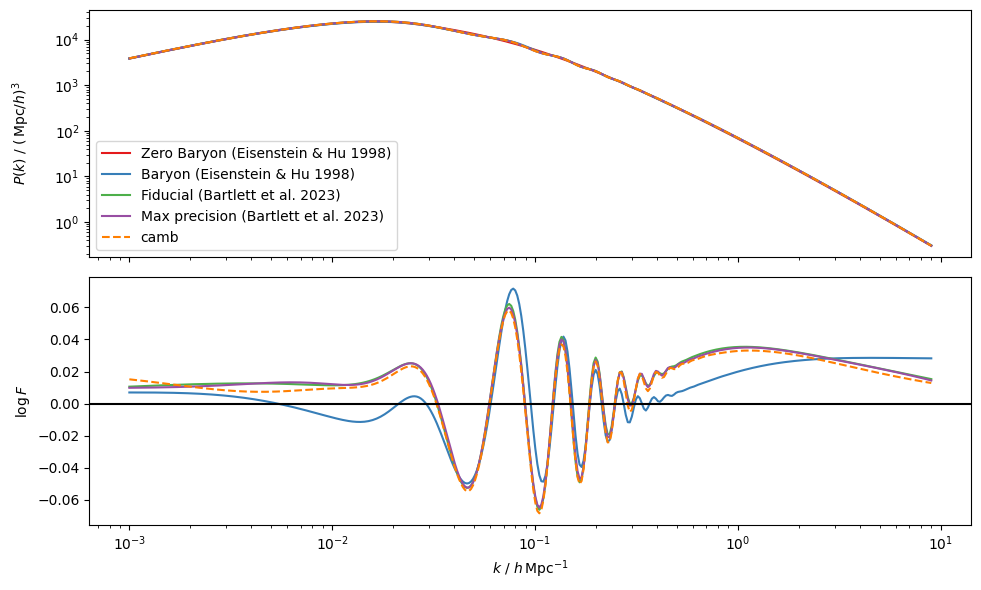

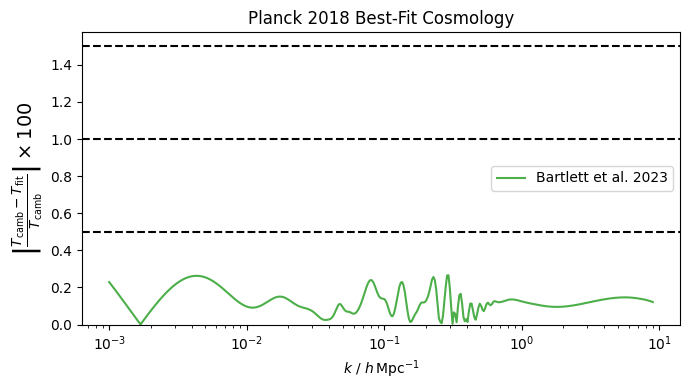

In [16]:
import symbolic_pofk.linear as linear
import camb

# Define k range
kmin = 1e-3
kmax = 9
nk = 400
k = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Cosmological parameters
As = 2.105  # 10^9 A_s
h = 0.6766
Om = 0.3111
Ob = 0.02242 / h ** 2
ns = 0.9665
tau = 0.0561
print("A_s", As)
print(f"Omegab={Ob}")
# Get sigma8 for this As
#sigma8_old = linear.As_to_sigma8(As, Om, Ob, h, ns, old_equation=True)
#print('sigma8 (old equation) = ', sigma8_old)
sigma8 = linear.As_to_sigma8(As, Om, Ob, h, ns)
print('sigma8 = ', sigma8)

# See what As you get in reverse
#As_new = linear.sigma8_to_As(sigma8_old, Om, Ob, h, ns, old_equation=True)
#print('As_new (old equation) = ', As_new)
As_new = linear.sigma8_to_As(sigma8, Om, Ob, h, ns)
print('As_new emulator = ', As_new)

# Emulate P(k)
pk_eh = linear.pk_EisensteinHu_zb(k, sigma8, Om, Ob, h, ns)
pk_eh_b = linear.pk_EisensteinHu_b(k, sigma8, Om, Ob, h, ns)
pk_fid = linear.plin_emulated(k, sigma8, Om, Ob, h, ns,
    emulator='fiducial', extrapolate=True)
pk_prec = linear.plin_emulated(k, sigma8, Om, Ob, h, ns,
    emulator='max_precision', extrapolate=True)
logF_eh_b = np.log(pk_eh_b / pk_eh)
logF_fid = linear.logF_fiducial(k, sigma8, Om, Ob, h, ns, extrapolate=True)
logF_prec = linear.logF_max_precision(k, sigma8, Om, Ob, h, ns, extrapolate=True)

# Compute P(k) using camb
pars = camb.CAMBparams()
pars.set_cosmology(H0 = h*100,
                   ombh2 = Ob * h ** 2,
                   omch2 = (Om - Ob) * h ** 2,
                   mnu = 0.0,
                   omk = 0,
                   tau=tau,)
As_fid = As_new *10**(-9) #2.0e-9
pars.InitPower.set_params(As=As_fid, ns=ns, r=0)
pars.set_matter_power(redshifts=[0.], kmax=k[-1])
pars.NonLinear = camb.model.NonLinear_none
results = camb.get_results(pars)
sigma8_camb = results.get_sigma8()[0]
print("sigma8 from camb: ", sigma8_camb)
#As_new2 = (sigma8 / sigma8_camb) ** 2 * As_fid
#print('As from camb', As_new2)
pars.InitPower.set_params(As=As_fid, ns=ns, r=0)
print("---printing all pars")

# List all attributes of pars
attributes = dir(pars)

# Filter and print only those containing 'nu'
nu_attributes = [attr for attr in attributes if 'nu' in attr]
for attr in nu_attributes:
    value = getattr(pars, attr)
    print(f"{attr}: {value}")

print("share delta neff , ", pars.share_delta_neff)
print("Neff , ", pars.N_eff)

results = camb.get_results(pars)
_, _, pk_camb = results.get_matter_power_spectrum(
                        minkh=k.min(), maxkh=k.max(), npoints=len(k))
pk_camb = pk_camb[0,:]
logF_camb = np.log(pk_camb / pk_eh)

fig, axs = plt.subplots(2, 1, figsize=(10,6), sharex=True)
cmap = plt.get_cmap('Set1')
axs[0].loglog(k, pk_eh, label='Zero Baryon (Eisenstein & Hu 1998)', color=cmap(0))
axs[0].loglog(k, pk_eh_b, label='Baryon (Eisenstein & Hu 1998)', color=cmap(1))
axs[0].loglog(k, pk_fid, label='Fiducial (Bartlett et al. 2023)', color=cmap(2))
axs[0].loglog(k, pk_prec, label='Max precision (Bartlett et al. 2023)', color=cmap(3))
axs[0].loglog(k, pk_camb, label='camb', color=cmap(4), ls='--')
axs[1].semilogx(k, logF_eh_b, label='Baryon', color=cmap(1))
axs[1].semilogx(k, logF_fid, label='Fiducial', color=cmap(2))
axs[1].semilogx(k, logF_prec, label='Max precision', color=cmap(3))
axs[1].semilogx(k, logF_camb, label='camb', color=cmap(4), ls='--')
axs[0].legend()
axs[1].set_xlabel(r'$k \ / \ h {\rm \, Mpc}^{-1}$')
axs[0].set_ylabel(r'$P(k) \ / \ ({\rm \, Mpc} / h)^3$')
axs[1].set_ylabel(r'$\log F$')
axs[1].axhline(0, color='k')
fig.align_labels()
fig.tight_layout()
fig.savefig('planck_2018_comparison.png', bbox_inches='tight')

fig2, ax2 = plt.subplots(1, 1, figsize=(7, 4))
frac_error = np.abs((np.sqrt(pk_camb) - np.sqrt(pk_fid)) / np.sqrt(pk_camb)) * 100
ax2.semilogx(k, frac_error, label='Bartlett et al. 2023', color=cmap(2))
ax2.legend()
for y in [0.5, 1.0, 1.5]:
    ax2.axhline(y, color='k', ls='--')
ax2.set_xlabel(r'$k \ / \ h {\rm \, Mpc}^{-1}$')
ax2.set_ylabel(r'$\left| \frac{T_{\rm camb} - T_{\rm fit}}{T_{\rm camb}} \right| \times 100$', fontsize=14)
ax2.set_title('Planck 2018 Best-Fit Cosmology')
ax2.set_ylim(0, None)
fig2.tight_layout()
fig2.savefig('planck_2018_errors.png', bbox_inches='tight')

plt.show()

## Pars comparison

In [17]:
syren_camb_pars = pars
syren_camb_pars

class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = False
   kmax = 9.0
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2500
 max_l_tensor = 600
 max_eta_k = 5000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.02242
 omch2 = 0.11999770991599999
 omk = 0.0
 omnuh2 = 0.0
 H0 = 67.66
 TCMB = 2.7255
 YHe = 0.24587684703799
 num_nu_massless = 3.044
 num_nu_massive = 0
 nu_mass_eigenstates = 0
 share_delta_neff = False
 nu_mass_degeneracies = []
 nu_mass_fractions = []
 nu_mass_numbers = []
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.9665
   nrun = 0.0
   nrunrun = 0.0
   nt = 0.0
   nt

In [18]:
syren_camb_pars.diff(CF_cambpars)

 WantCls = False  <->   WantCls = True
 Want_cl_2D_array = False  <->   Want_cl_2D_array = True
 Want_CMB = False  <->   Want_CMB = True
 Want_CMB_lensing = False  <->   Want_CMB_lensing = True
 NonLinear = NonLinear_both  <->   NonLinear = NonLinear_none
   kmax = 10.0  <->     kmax = 9.0
   k_per_logint = 50  <->     k_per_logint = 0
   PK_num_redshifts = 100  <->     PK_num_redshifts = 1
   PK_redshifts = [5.0, 4.94949494949495, 4.898989898989899, 4.848484848484849, 4.797979797979798, 4.747474747474747, 4.696969696969697, ...]  <->     PK_redshifts = [0.0]
 max_l = 4150  <->   max_l = 2500
 max_eta_k = 18000.0  <->   max_eta_k = 5000.0
 ombh2 = 0.0224178568132  <->   ombh2 = 0.02242
 omch2 = 0.11999985310280001  <->   omch2 = 0.11999770991599999
 YHe = 0.2454006  <->   YHe = 0.24587684703799
   nt = -0.0  <->     nt = 0.0
   As = 2.1098301595078886e-09  <->     As = 2.105e-09
   Reionization = False  <->     Reionization = True
 DarkEnergy: <DarkEnergyPPF>  <->   DarkEnergy: <DarkEn

# Comparison plots

In [19]:
sobo.results.Pk_l(0., sobo.kgridMpc, grid=False).shape

(400,)

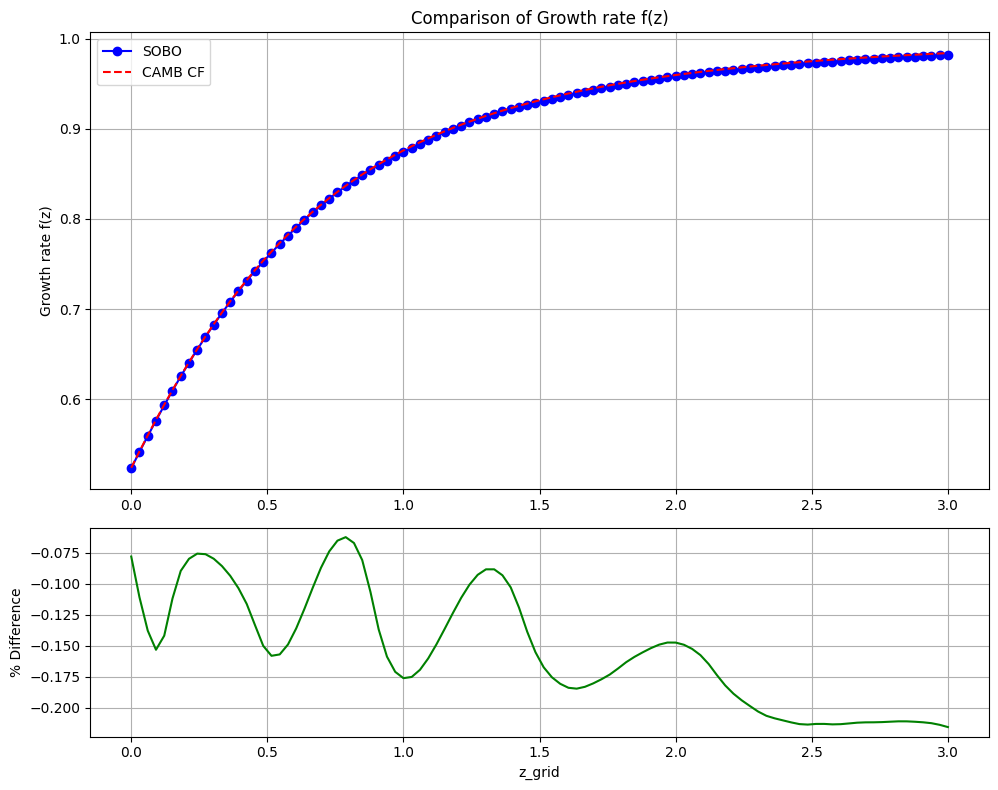

In [29]:
thresh = 1e-10
zz = sobo.zgrid
kkk = 0.01
sobo_quant = np.clip(sobo.results.f_growthrate_zk(zz, kkk, grid=False), thresh, None)
camb_quant = np.clip(cfg.fiducialcosmo.f_growthrate(zz), thresh, None)
quant = f'Growth rate f(z)'
x_axis = zz

percentage_diff  = (100*(sobo_quant - camb_quant)/camb_quant)

fig = plt.figure(figsize=(10, 8))

# First subplot: Angular Distance comparison (occupies most of the space)
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)  # 2/3 of height
ax1.plot(x_axis, sobo_quant, color='blue', marker='o', label='SOBO')
ax1.plot(x_axis, camb_quant, ls='--', color='red', label='CAMB CF')
#ax1.loglog(k, pk_camb, label='camb from ex.', color='green', ls='--')
#ax1.loglog(k, pk_prec, label='Max precision (Bartlett et al. 2023)', color=cmap(3), ls=':')
#ax1.set_xlabel('z_grid')
ax1.set_ylabel(quant)
ax1.set_title('Comparison of '+quant)
ax1.legend()
ax1.grid(True)

# Second subplot: Percentage Difference (occupies less space)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)  # 1/3 of height
ax2.plot(x_axis, percentage_diff, color='green', label='Percentage Difference')
ax2.set_xlabel('z_grid')
ax2.set_ylabel('% Difference')
#ax2.set_ylim(-1,1)
ax2.grid(True)


# Adjust layout to prevent overlap
plt.tight_layout()

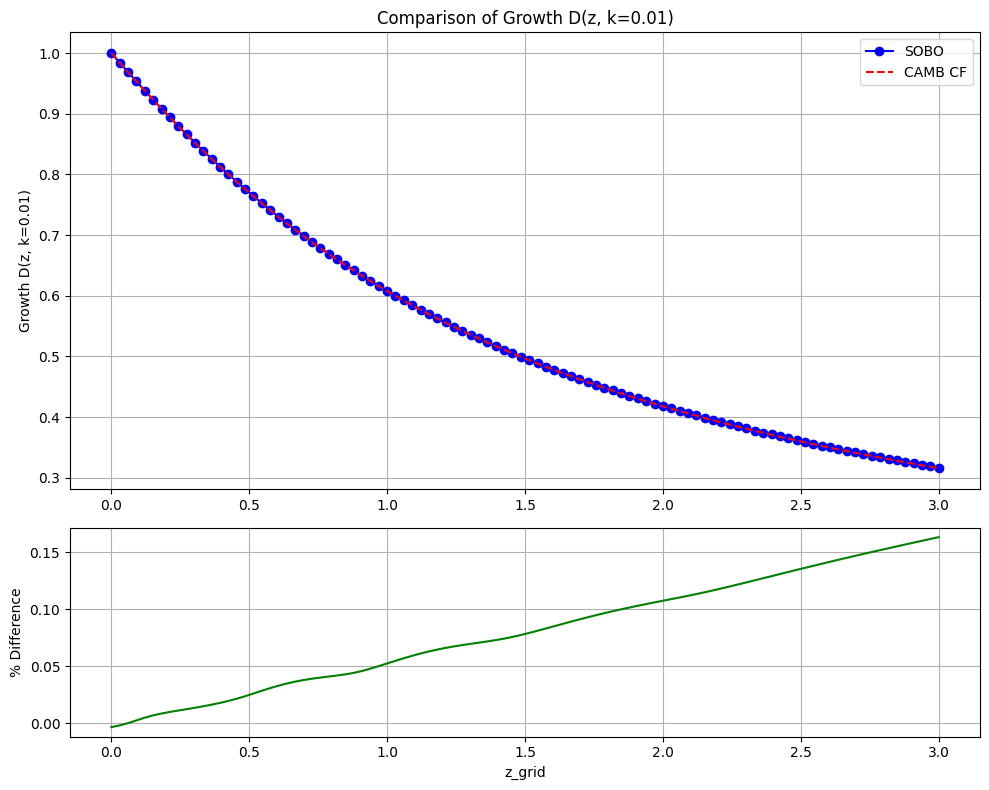

In [ ]:
thresh = 1e-10
zz = sobo.zgrid
kkk = 0.01
sobo_quant = np.clip(sobo.results.D_growth_zk(zz, kkk, grid=False), thresh, None)
camb_quant = np.clip(cfg.fiducialcosmo.growth(zz), thresh, None)
quant = f'Growth D(z, k=0.01)'
x_axis = zz

percentage_diff  = (100*(sobo_quant - camb_quant)/camb_quant)

fig = plt.figure(figsize=(10, 8))

# First subplot: Angular Distance comparison (occupies most of the space)
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)  # 2/3 of height
ax1.plot(x_axis, sobo_quant, color='blue', marker='o', label='SOBO')
ax1.plot(x_axis, camb_quant, ls='--', color='red', label='CAMB CF')
#ax1.loglog(k, pk_camb, label='camb from ex.', color='green', ls='--')
#ax1.loglog(k, pk_prec, label='Max precision (Bartlett et al. 2023)', color=cmap(3), ls=':')
#ax1.set_xlabel('z_grid')
ax1.set_ylabel(quant)
ax1.set_title('Comparison of '+quant)
ax1.legend()
ax1.grid(True)

# Second subplot: Percentage Difference (occupies less space)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)  # 1/3 of height
ax2.plot(x_axis, percentage_diff, color='green', label='Percentage Difference')
ax2.set_xlabel('z_grid')
ax2.set_ylabel('% Difference')
#ax2.set_ylim(-1,1)
ax2.grid(True)


# Adjust layout to prevent overlap
plt.tight_layout()

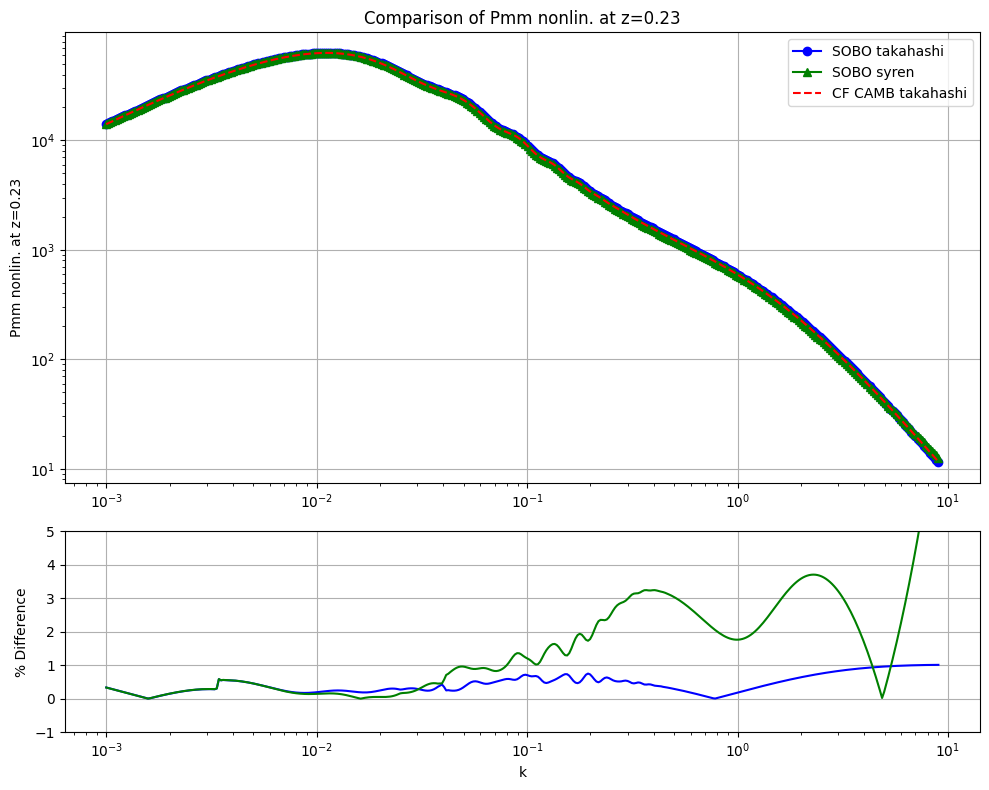

In [45]:
thresh = 1e-10
sobohalo = soso(fiducial, feed_lvl=1, halofit_version='takahashi')
sobohalo.symbolic_results()
sobosyren = soso(fiducial, feed_lvl=1, halofit_version='syren', extrapolate=True)
sobosyren.symbolic_results()
kmpc = sobohalo.kgridMpc
zz = 0.23
sobo_quant_halo = np.clip(sobohalo.results.Pk_nl(zz, kmpc, grid=False), thresh, None)
sobo_quant_syren = np.clip(sobosyren.results.Pk_nl(zz, kmpc, grid=False), thresh, None)
camb_quant = np.clip(cfg.fiducialcosmo.Pmm(zz, kmpc, nonlinear=True), thresh, None)
quant = f'Pmm nonlin. at z={zz}'

percentage_diff_halo = np.abs(100*(sobo_quant_halo - camb_quant)/camb_quant)
percentage_diff_syren = np.abs(100*(sobo_quant_syren - camb_quant)/camb_quant)

fig = plt.figure(figsize=(10, 8))

# First subplot: Angular Distance comparison (occupies most of the space)
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)  # 2/3 of height
ax1.loglog(kmpc, sobo_quant_halo, color='blue', marker='o', label='SOBO takahashi')
ax1.loglog(kmpc, sobo_quant_syren, color='green', marker='^', label='SOBO syren')
ax1.loglog(kmpc, camb_quant, ls='--', color='red', label='CF CAMB takahashi')
#ax1.loglog(k, pk_camb, label='camb from ex.', color='green', ls='--')
#ax1.loglog(k, pk_prec, label='Max precision (Bartlett et al. 2023)', color=cmap(3), ls=':')
#ax1.set_xlabel('z_grid')
ax1.set_ylabel(quant)
ax1.set_title('Comparison of '+quant)
ax1.legend()
ax1.grid(True)

# Second subplot: Percentage Difference (occupies less space)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)  # 1/3 of height
ax2.semilogx(kmpc, percentage_diff_halo, color='blue', label='takahashi')
ax2.semilogx(kmpc, percentage_diff_syren, color='green', label='syren')
ax2.set_xlabel('k')
ax2.set_ylabel('% Difference')
ax2.set_ylim(-1,5)
ax2.grid(True)


# Adjust layout to prevent overlap
plt.tight_layout()

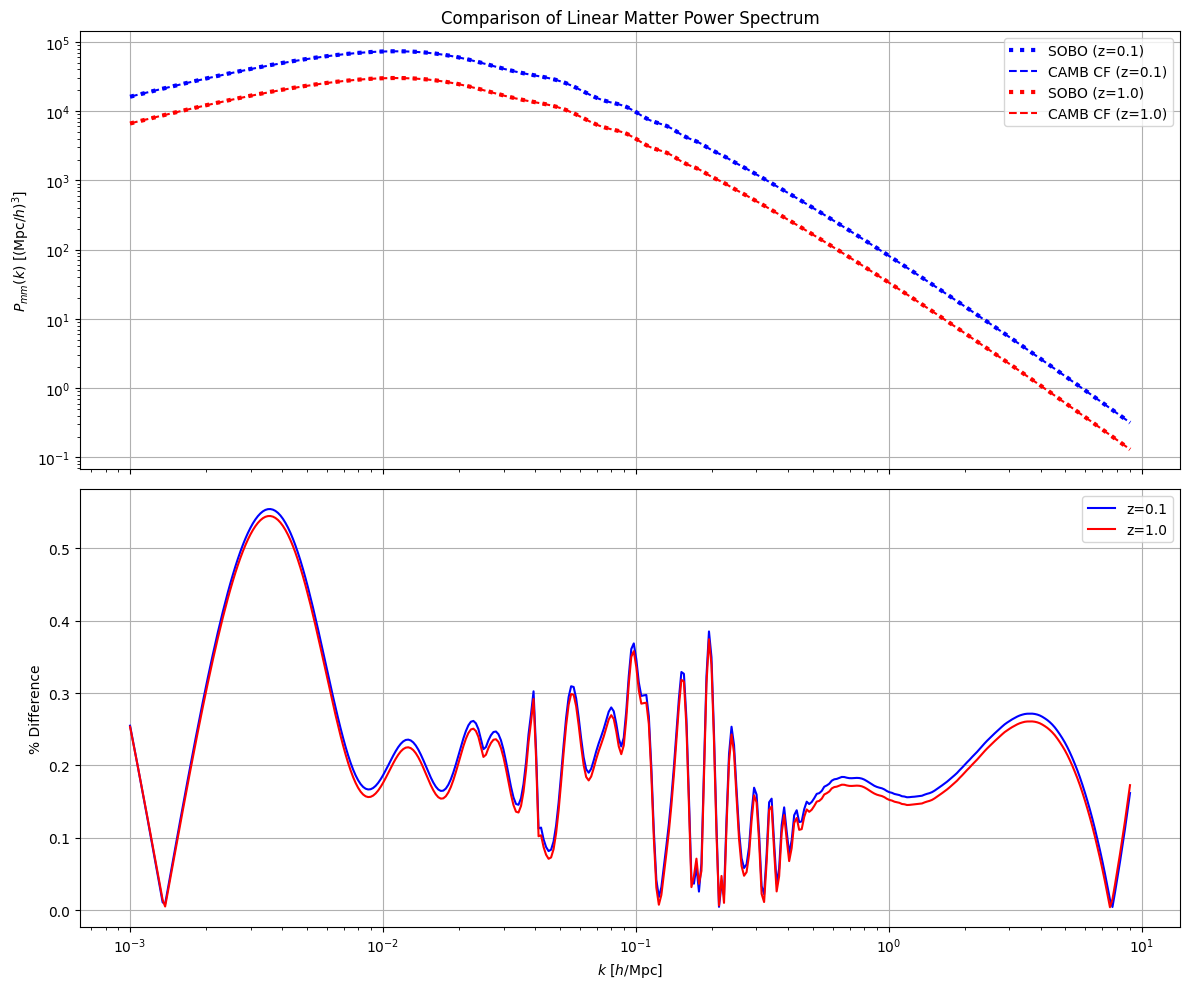

In [22]:
thresh = 1e-10
kmpc = sobo.kgridMpc
z1, z2 = 0.1, 1.0  # Two different redshifts

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Colors and line styles
colors = ['blue', 'red']
linestyles = [':', '--']

for i, z in enumerate([z1, z2]):
    sobo_quant = np.clip(sobo.results.Pk_l(z, kmpc, grid=False), thresh, None)
    camb_quant = np.clip(cfg.fiducialcosmo.Pmm(z, kmpc, nonlinear=False), thresh, None)
    
    percentage_diff = np.abs(100 * (sobo_quant - camb_quant) / camb_quant)
    
    # Power spectrum plot
    ax1.loglog(kmpc, sobo_quant, color=colors[i], ls=linestyles[0], 
               label=f'SOBO (z={z})', lw=3)
    ax1.loglog(kmpc, camb_quant, color=colors[i], ls=linestyles[1], 
               label=f'CAMB CF (z={z})')
    
    # Percentage difference plot
    ax2.semilogx(kmpc, percentage_diff, color=colors[i], 
                 label=f'z={z}')

ax1.set_ylabel(r'$P_{mm}(k) \ [(\mathrm{Mpc}/h)^3]$')
ax1.set_title('Comparison of Linear Matter Power Spectrum')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel(r'$k \ [h/\mathrm{Mpc}]$')
ax2.set_ylabel('% Difference')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

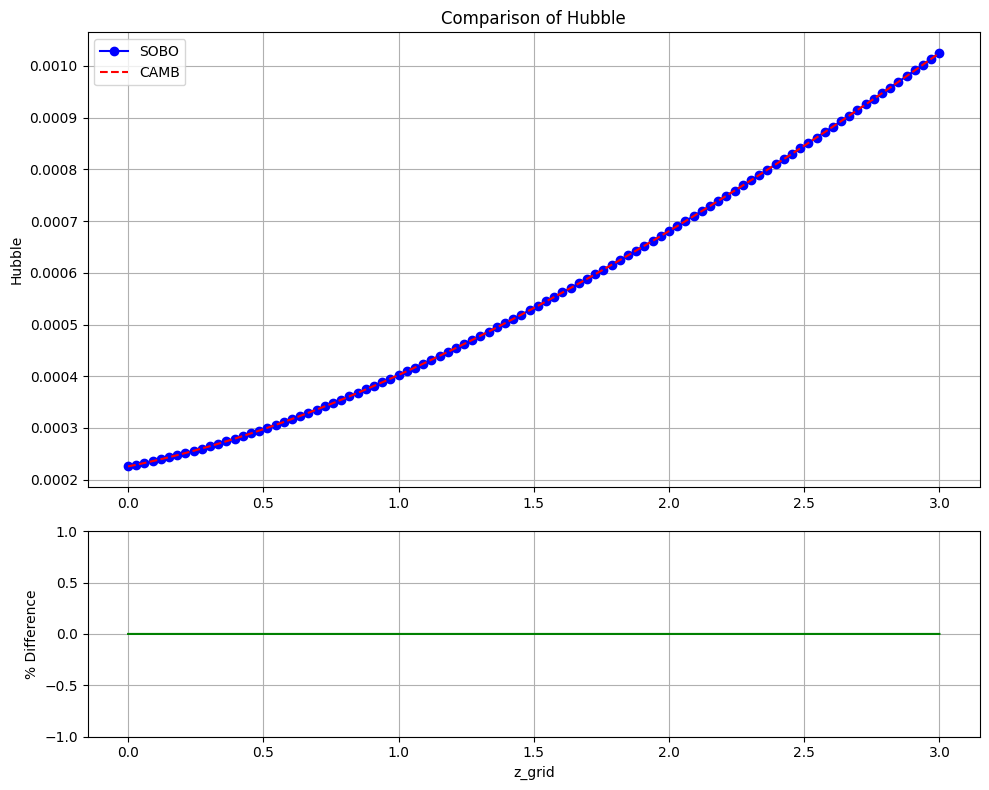

In [23]:
thresh = 1e-10
z_grid = sobo.zgrid
sobo_quant = np.clip(sobo.results.h_of_z(z_grid), thresh, None)
camb_quant = np.clip(cfg.fiducialcosmo.Hubble(z_grid), thresh, None)
quant = 'Hubble'

percentage_diff  = 100*(sobo_quant - camb_quant)/camb_quant

fig = plt.figure(figsize=(10, 8))

# First subplot: Angular Distance comparison (occupies most of the space)
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)  # 2/3 of height
ax1.plot(z_grid, sobo_quant, color='blue', marker='o', label='SOBO')
ax1.plot(z_grid, camb_quant, ls='--', color='red', label='CAMB')
#ax1.set_xlabel('z_grid')
ax1.set_ylabel(quant)
ax1.set_title('Comparison of '+quant)
ax1.legend()
ax1.grid(True)

# Second subplot: Percentage Difference (occupies less space)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)  # 1/3 of height
ax2.plot(z_grid, percentage_diff, color='green', label='Percentage Difference')
ax2.set_xlabel('z_grid')
ax2.set_ylabel('% Difference')
ax2.set_ylim(-1,1)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

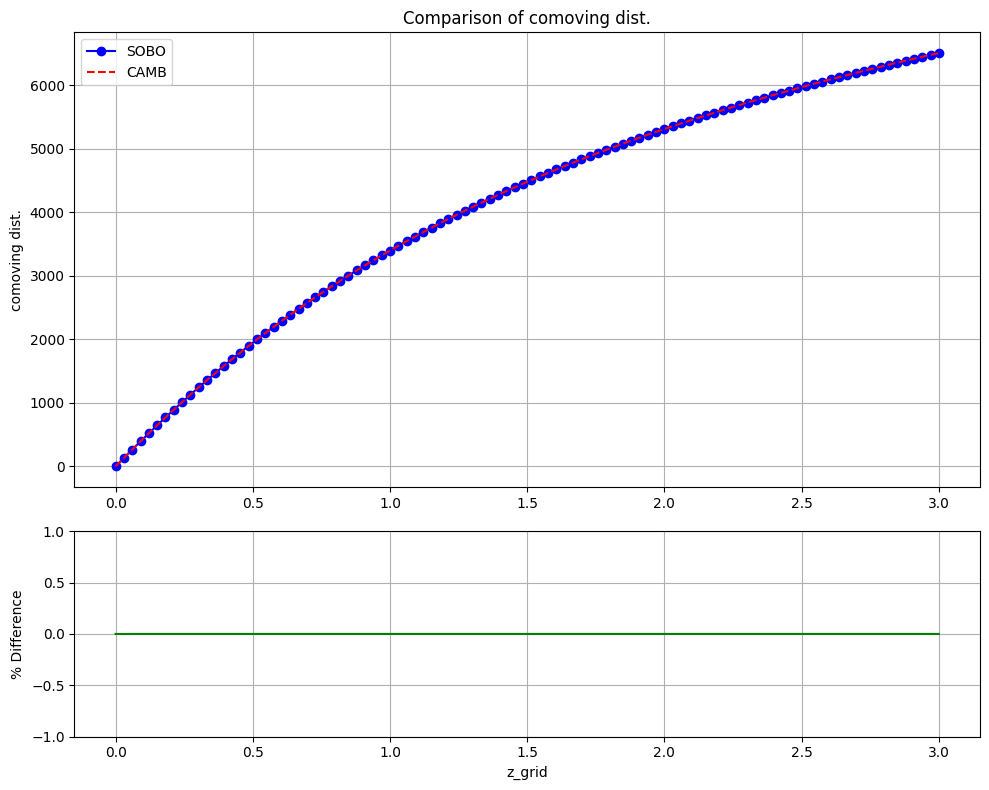

In [28]:
thresh = 1e-10
sobo_quant = np.clip(sobo.results.com_dist(z_grid), thresh, None)
camb_quant = np.clip(cfg.fiducialcosmo.comoving(z_grid), thresh, None)
quant = 'comoving dist.'

percentage_diff  = 100*(sobo_quant - camb_quant)/camb_quant

fig = plt.figure(figsize=(10, 8))

# First subplot: Angular Distance comparison (occupies most of the space)
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)  # 2/3 of height
ax1.plot(z_grid, sobo_quant, color='blue', marker='o', label='SOBO')
ax1.plot(z_grid, camb_quant, ls='--', color='red', label='CAMB')
#ax1.set_xlabel('z_grid')
ax1.set_ylabel(quant)
ax1.set_title('Comparison of '+quant)
ax1.legend()
ax1.grid(True)

# Second subplot: Percentage Difference (occupies less space)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)  # 1/3 of height
ax2.plot(z_grid, percentage_diff, color='green', label='Percentage Difference')
ax2.set_xlabel('z_grid')
ax2.set_ylabel('% Difference')
ax2.set_ylim(-1,1)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

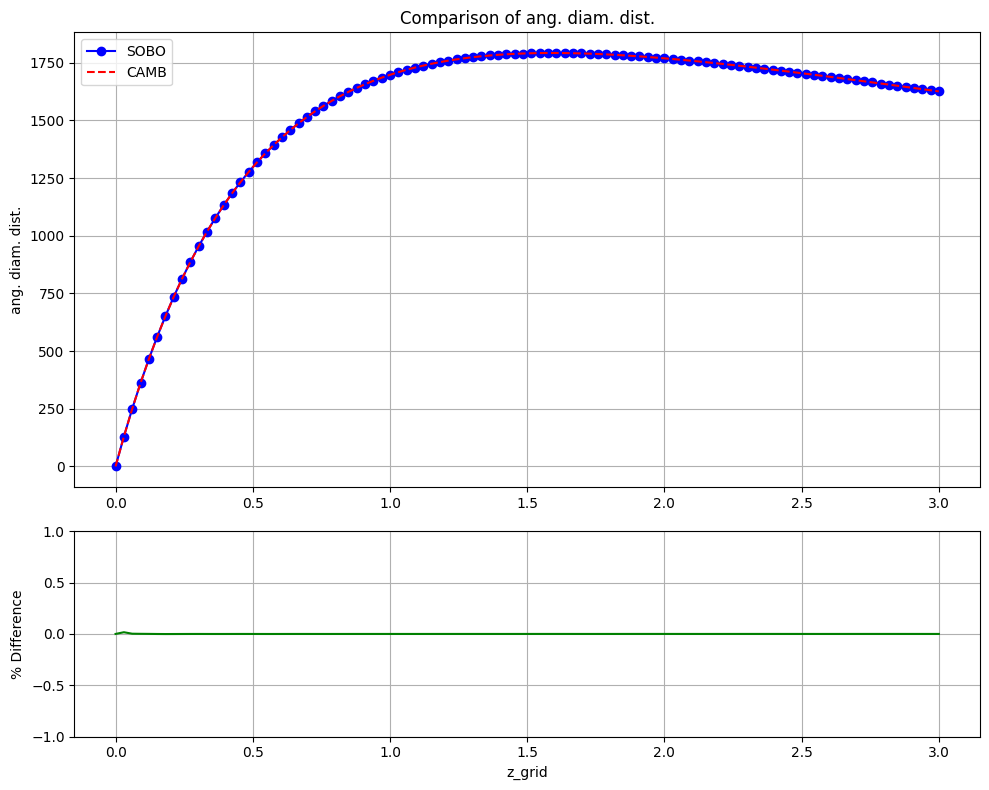

In [26]:
thresh = 1e-10
sobo_quant = np.clip(sobo.results.ang_dist(z_grid), thresh, None)
camb_quant = np.clip(cfg.fiducialcosmo.angdist(z_grid), thresh, None)
quant = 'ang. diam. dist.'

percentage_diff  = 100*(sobo_quant - camb_quant)/camb_quant

fig = plt.figure(figsize=(10, 8))

# First subplot: Angular Distance comparison (occupies most of the space)
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)  # 2/3 of height
ax1.plot(z_grid, sobo_quant, color='blue', marker='o', label='SOBO')
ax1.plot(z_grid, camb_quant, ls='--', color='red', label='CAMB')
#ax1.set_xlabel('z_grid')
ax1.set_ylabel(quant)
ax1.set_title('Comparison of '+quant)
ax1.legend()
ax1.grid(True)

# Second subplot: Percentage Difference (occupies less space)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)  # 1/3 of height
ax2.plot(z_grid, percentage_diff, color='green', label='Percentage Difference')
ax2.set_xlabel('z_grid')
ax2.set_ylabel('% Difference')
ax2.set_ylim(-1,1)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

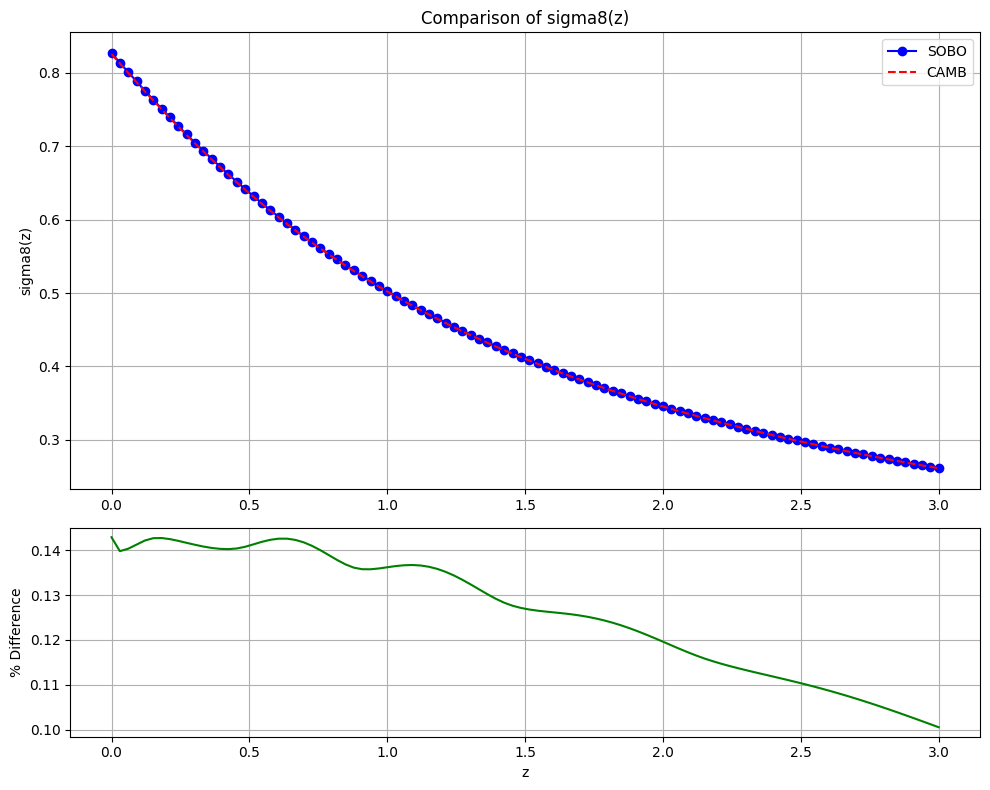

In [27]:
thresh = 1e-10
sobo_quant = np.clip(sobo.results.s8_of_z(z_grid), thresh, None)
camb_quant = np.clip(cfg.fiducialcosmo.sigma8_of_z(z_grid), thresh, None)
quant = 'sigma8(z)'

percentage_diff  = 100*(sobo_quant - camb_quant)/camb_quant

fig = plt.figure(figsize=(10, 8))

# First subplot: Angular Distance comparison (occupies most of the space)
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)  # 2/3 of height
ax1.plot(z_grid, sobo_quant, color='blue', marker='o', label='SOBO')
ax1.plot(z_grid, camb_quant, ls='--', color='red', label='CAMB')
#ax1.set_xlabel('z_grid')
ax1.set_ylabel(quant)
ax1.set_title('Comparison of '+quant)
ax1.legend()
ax1.grid(True)

# Second subplot: Percentage Difference (occupies less space)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)  # 1/3 of height
ax2.plot(z_grid, percentage_diff, color='green', label='Percentage Difference')
ax2.set_xlabel('z')
ax2.set_ylabel('% Difference')
#ax2.set_ylim(-1,1)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

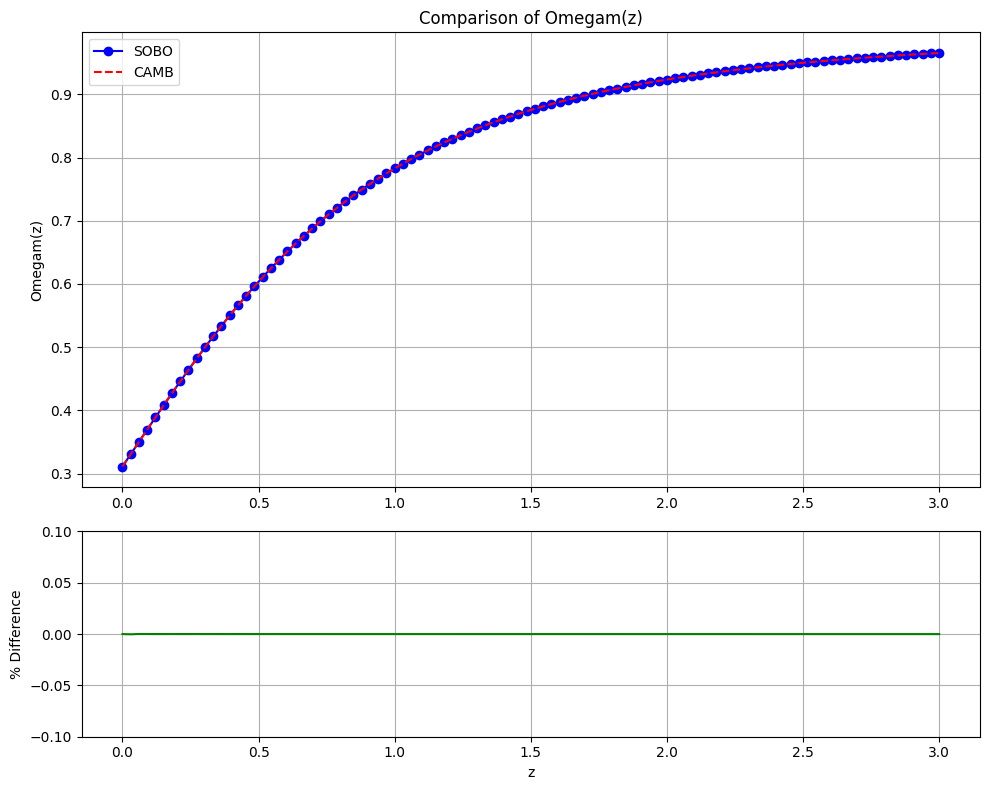

In [28]:
thresh = 1e-10
sobo_quant = np.clip(sobo.results.Om_m(z_grid), thresh, None)
camb_quant = np.clip(cfg.fiducialcosmo.Omegam_of_z(z_grid), thresh, None)
quant = 'Omegam(z)'

percentage_diff  = 100*(sobo_quant - camb_quant)/camb_quant

fig = plt.figure(figsize=(10, 8))

# First subplot: Angular Distance comparison (occupies most of the space)
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)  # 2/3 of height
ax1.plot(z_grid, sobo_quant, color='blue', marker='o', label='SOBO')
ax1.plot(z_grid, camb_quant, ls='--', color='red', label='CAMB')
#ax1.set_xlabel('z_grid')
ax1.set_ylabel(quant)
ax1.set_title('Comparison of '+quant)
ax1.legend()
ax1.grid(True)

# Second subplot: Percentage Difference (occupies less space)
ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)  # 1/3 of height
ax2.plot(z_grid, percentage_diff, color='green', label='Percentage Difference')
ax2.set_xlabel('z')
ax2.set_ylabel('% Difference')
ax2.set_ylim(-0.1,0.1)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

## Symbolic functions

# Photometric 3x2pt Angular Power Spectrum Observable

The 3x2pt function is the auto- and cross-correlation of observables X, Y = {L, G},  which can be combined in 3 times the 2pt-function of:
Lensing-Lensing, Galaxy-Lensing and Galaxy-Galaxy

$$
C_{ij}^{XY}(\ell) = \int^{z_{max}}_{z_{min}} \!\!\!\!\! dz  \frac{W_{i}^{X}(z) W_{j}^{Y}(z)}{H(z)r^{2}(z)} P_{\delta \delta} \! \left[ \frac{\ell+1/2}{r(z)},z \right] +N_{ij}^{XY}(\ell)
$$

where the cosmic shear window function is given by:

$$
W_i^{\gamma}(z) = \frac{3}{2} \, H_0^2 \, \Omega_m \,  (1+z) \, r(z) \int_z^{z_{max}}dz^\prime \,
    %\niof(z') 
    n_i(z^\prime)
    \left[1- \frac{r(z)}{r(z^\prime)}\right]~
$$

and the estimated number density of galaxies in each bin is given by:

$$
n_i(z) = \frac{\int_{z_i^-}^{z_i^+} dz_p n(z) p_{ph}(z_p|z)}{\int_{z_{min}}^{z_{max}}dz \int_{z_i^-}^{z_i^+}dz_p n(z) p_{ph}(z_p|z)}~
$$

which is a convolution of the theoretical mean number density with a photometric redshift error distribution:

$$
p_{ph}(z_p|z) = \frac{1-f_{out}}{\sqrt{2\pi}\sigma_b(1+z)} \exp\left\{-\frac{1}{2}\left[\frac{z-c_bz_p-z_b}{\sigma_b(1+z)}\right]^2\right\} \\ + \frac{f_{out}}{\sqrt{2\pi}\sigma_0(1+z)} \exp\left\{-\frac{1}{2}\left[\frac{z-c_0z_p-z_0}{\sigma_0(1+z)}\right]^2\right\}
$$

The full lensing function is given by the addition of cosmic shear and intrinsic alignment, which takes the following form:

$$
W_{i}^{L}(z) = W_{i}^{\gamma}(z) - W_{i}^\mathrm{IA}(z) 
$$

Moreover for IA and for photometric Galaxy clustering, the window function takes the simple form:

$$
W_{i}^\mathrm{IA}(z) = \mathcal{A}_\mathrm{IA} \mathcal{C}_\mathrm{IA}\Omega_{m,0} \frac{\mathcal{F}_\mathrm{IA}(z)}{D(z)} n_i(z) H(z)\\
W_{i}^{G}(z) = n_i(z) H(z)\, b_i(z)
$$

Here, $b_i(z)$ is the galaxy bias (the ratio between the density contrast of galaxies and dark matter).

In [7]:
observables = ['GCph', 'WL']

### Pass options and settings to cosmicfish

In [8]:
cosmoFM_A = cosmicfish.FisherMatrix(fiducialpars=fiducial,
                                        options=options, 
                                        observables=observables,
                                        cosmoModel=options['cosmo_model'],
                                        surveyName=options['survey_name'])

**************************************************************
   _____               _     _____     __  
  / ___/__  ___ __ _  (_)___/ __(_)__ / /  
 / /__/ _ \(_-</  ' \/ / __/ _// (_-</ _ \ 
 \___/\___/___/_/_/_/_/\__/_/ /_/___/_//_/ 

**************************************************************
 This is the new Python version of the CosmicFish code.
**************************************************************
Custom fiducial parameters loaded

  -> Computing cosmology at the fiducial point

  ---> Cosmological functions obtained in:   3.50 s

----------RECAP OF SELECTED OPTIONS--------

Settings:
   accuracy: 1
   feedback: 1
   code: camb
   outroot: LCDM-camb
   specs_dir: ../survey_specifications/
   survey_name: Euclid
   cosmo_model: LCDM
   camb_path: /home/santiago/anaconda3/envs/cosmicfishpie/lib/python3.10/site-packages/camb
   survey_specs: ISTF-Optimistic
   survey_name_photo: 
   survey_name_spectro: 
   derivatives: 3PT
   nonlinear: True
   nonlinear_photo: True


#### By setting `survey_name=Euclid` above, we have implicitly chose a default set of observational parameters to be used for the photometric probe

In [9]:
cosmoFM_A.fiducialcosmopars

{'Omegam': 0.32,
 'Omegab': 0.05,
 'h': 0.67,
 'ns': 0.96,
 'As': 2.0483976e-09,
 'w0': -1.0,
 'wa': 0.0,
 'mnu': 0.06,
 'Neff': 3.044}

In [10]:
cosmoFM_A.biaspars

{'bias_model': 'binned',
 'b1': 1.0997727037892875,
 'b2': 1.220245876862528,
 'b3': 1.2723993083933989,
 'b4': 1.316624471897739,
 'b5': 1.35812370570578,
 'b6': 1.3998214171814918,
 'b7': 1.4446452851824907,
 'b8': 1.4964959071110084,
 'b9': 1.5652475842498528,
 'b10': 1.7429859437184225}

In [11]:
cosmoFM_A.photopars

{'fout': 0.1,
 'co': 1,
 'cb': 1,
 'sigma_o': 0.05,
 'sigma_b': 0.05,
 'zo': 0.1,
 'zb': 0.0}

In [12]:
cosmoFM_A.IApars

{'IA_model': 'eNLA', 'AIA': 1.72, 'betaIA': 2.17, 'etaIA': -0.41}

# Compute the Photometric angular power spectrum $C(\ell)$

In [12]:
## Import the photometric observable from an LSSsurvey as phobs
from cosmicfishpie.LSSsurvey import photo_obs as phobs

#### Declare an instance of the class

In [13]:
photo_Cls = phobs.ComputeCls(cosmoFM_A.fiducialcosmopars, 
                             cosmoFM_A.photopars, cosmoFM_A.IApars, 
                             cosmoFM_A.biaspars)


In class: ComputeCls  -> Started Cls calculation

In class: ComputeCls  ---> Cosmological functions obtained in   5.75 s


#### Compute the actual $C_\ell$

In [14]:
phCls_A = photo_Cls.compute_all()


In class: ComputeCls  -> Computing power spectra and kernels 

In class: ComputeCls  --> Total Cls computation performed in :   1.47 s


 ##  Let's first extract the cosmological ingredients separately

In [15]:
zz = np.linspace(0.001,5.0,250)   ## declare a z-array
kk = np.logspace(np.log10(1e-3),np.log10(10),250)  ## declare a k-array

In [16]:
cosmofuncs = photo_Cls.cosmo  ## Access the cosmo attribute of the photometric observable
                              ## All observables in CF have a cosmo attribute

In [17]:
method_list = [attribute for attribute in dir(cosmofuncs) if callable(getattr(cosmofuncs, attribute)) 
               and attribute.startswith('__') is False]
print(method_list)

['E_hubble', 'Hubble', 'Omegam_of_z', 'Pcb', 'Pmm', 'SigmaMG', 'angdist', 'cmb_power', 'comoving', 'f_growthrate', 'fsigma8_of_z', 'growth', 'matpow', 'nonwiggle_pow', 'sigma8_of_z']


### Background and linear perturbations

In [18]:
chi_z = cosmofuncs.comoving(zz)
ang_z = cosmofuncs.angdist(zz)
hub_z = cosmofuncs.Hubble(zz, physical=True)
D_growth_z = cosmofuncs.growth(zz)
f_growthrate_z = cosmofuncs.f_growthrate(zz)

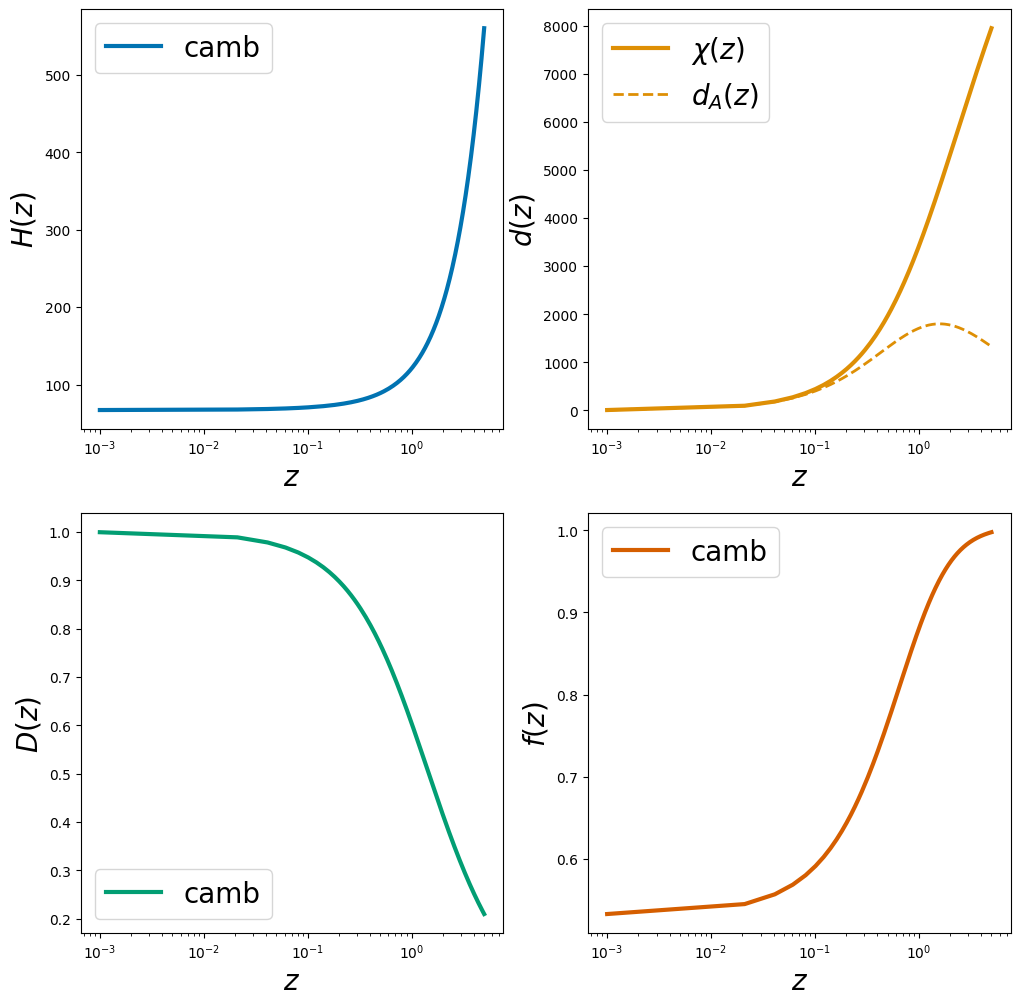

In [19]:
fig, axs = plt.subplots(2,2, figsize=(12,12))
codelab = options['code']
axs[0,0].semilogx(zz, hub_z, color=snscolors[0], lw=3, label=codelab)
axs[0,0].set_xlabel('$z$',fontsize=20)
axs[0,0].set_ylabel(r'$H(z)$',fontsize=20)
axs[0,0].legend(loc='best',fontsize=20)

axs[0,1].semilogx(zz, chi_z, color=snscolors[1], lw=3, label=r'$\chi(z)$')
axs[0,1].semilogx(zz, ang_z, color=snscolors[1], lw=2, ls='--',  label=r'$d_A (z)$')
axs[0,1].set_xlabel('$z$',fontsize=20)
axs[0,1].set_ylabel(r'$d(z)$',fontsize=20)
axs[0,1].legend(loc='best',fontsize=20)

axs[1,0].semilogx(zz, D_growth_z, color=snscolors[2], lw=3, label=codelab)
axs[1,0].set_xlabel('$z$',fontsize=20)
axs[1,0].set_ylabel(r'$D(z)$',fontsize=20)
axs[1,0].legend(loc='best',fontsize=20)

axs[1,1].semilogx(zz, f_growthrate_z, color=snscolors[3], lw=3, label=codelab)
axs[1,1].set_xlabel('$z$',fontsize=20)
axs[1,1].set_ylabel(r'$f(z)$',fontsize=20)
axs[1,1].legend(loc='best',fontsize=20)

### The matter power spectrum

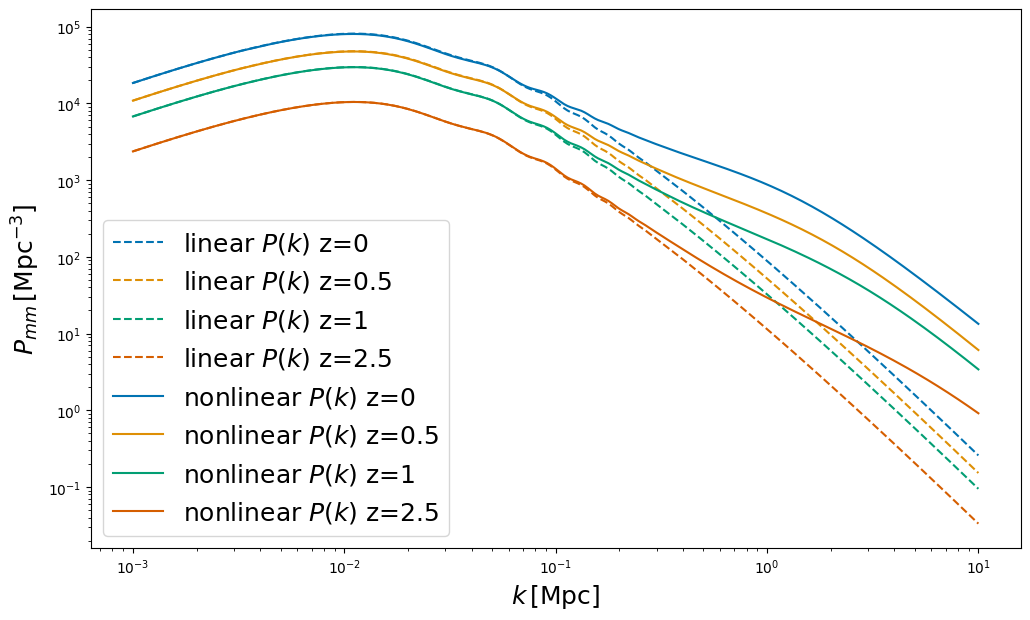

In [20]:
fig, axs = plt.subplots(1,1, figsize=(12,7))
color=iter(snscolors)
zplot = [0, 0.5, 1, 2.5]
for zii in zplot:
    c=next(color)
    axs.loglog(kk, cosmofuncs.matpow(zii, kk, nonlinear=False), ls='--', c=c, label='linear $P(k)$ z=%s'%zii)
axs.set_xlabel(r'$k \, [\mathrm{Mpc}]$', fontsize=18)
axs.set_ylabel(r'$P_{mm} \, [\mathrm{Mpc}^{-3}]$', fontsize=18)
color=iter(snscolors)
for zii in zplot:
    c=next(color)
    axs.loglog(kk, cosmofuncs.matpow(zii, kk, nonlinear=True), ls='-', c=c, label='nonlinear $P(k)$ z=%s'%zii)
axs.legend(fontsize=18)

### Extract the Window Functions from Cosmicfish

In [21]:
zz = np.linspace(0.001, 2.5, 250)   ## Euclid specs are only defined up to z=3.

In [22]:
ph_window = photo_Cls.window

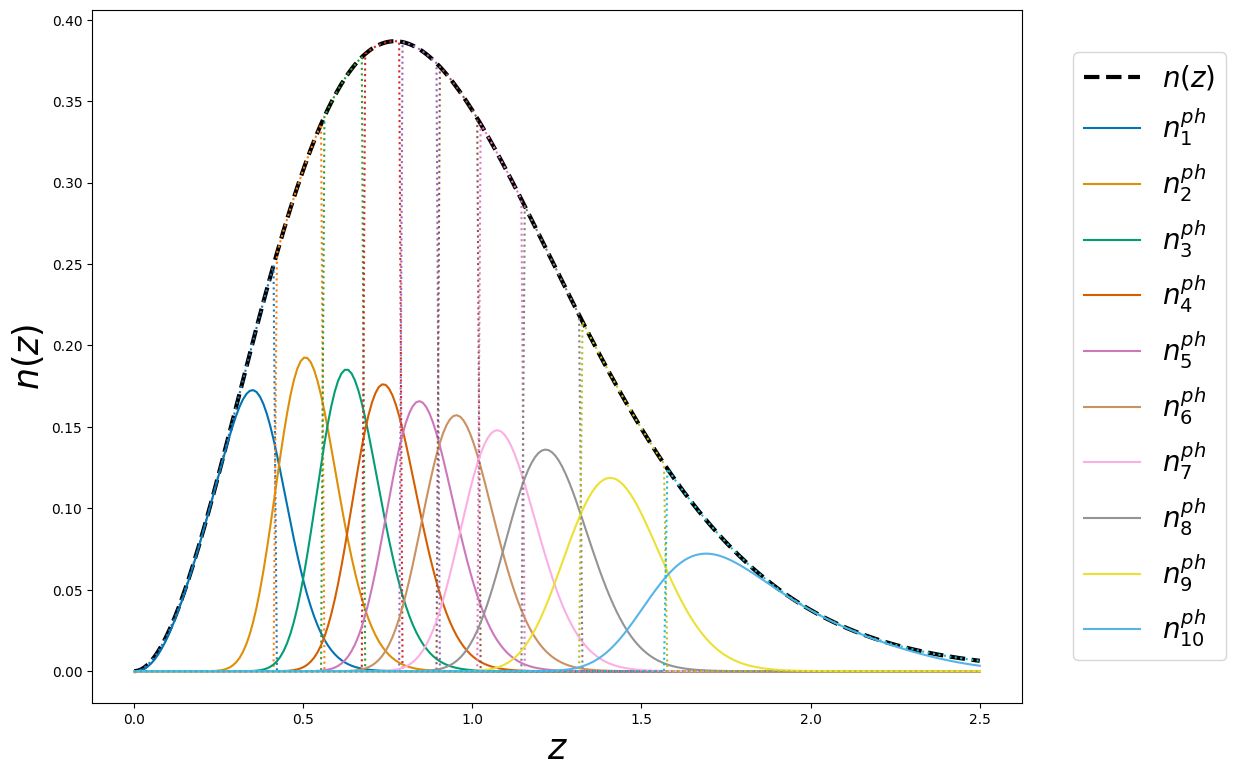

In [23]:
#Full window function and binned photo n(z) distribution
window = photo_Cls.window

color=iter(snscolors)
plt.figure(figsize=(12, 9))
plt.plot(zz, window.dNdz(zz),label=r'$n(z)$', color='k', lw=3, ls='--')
for ind in photo_Cls.binrange:
    c = next(color)
    plt.plot(zz, window.ngal_photoz(zz, ind), label=r'$n^{ph}_{%s}$' %ind, color=c)
    plt.plot(zz, window.n_i(zz, ind), ls=':') #label=r'dNi bin-'+str(ind), color=c)
plt.xlabel(r'$z$',fontsize=25)
plt.ylabel(r'$n(z)$',fontsize=25)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)

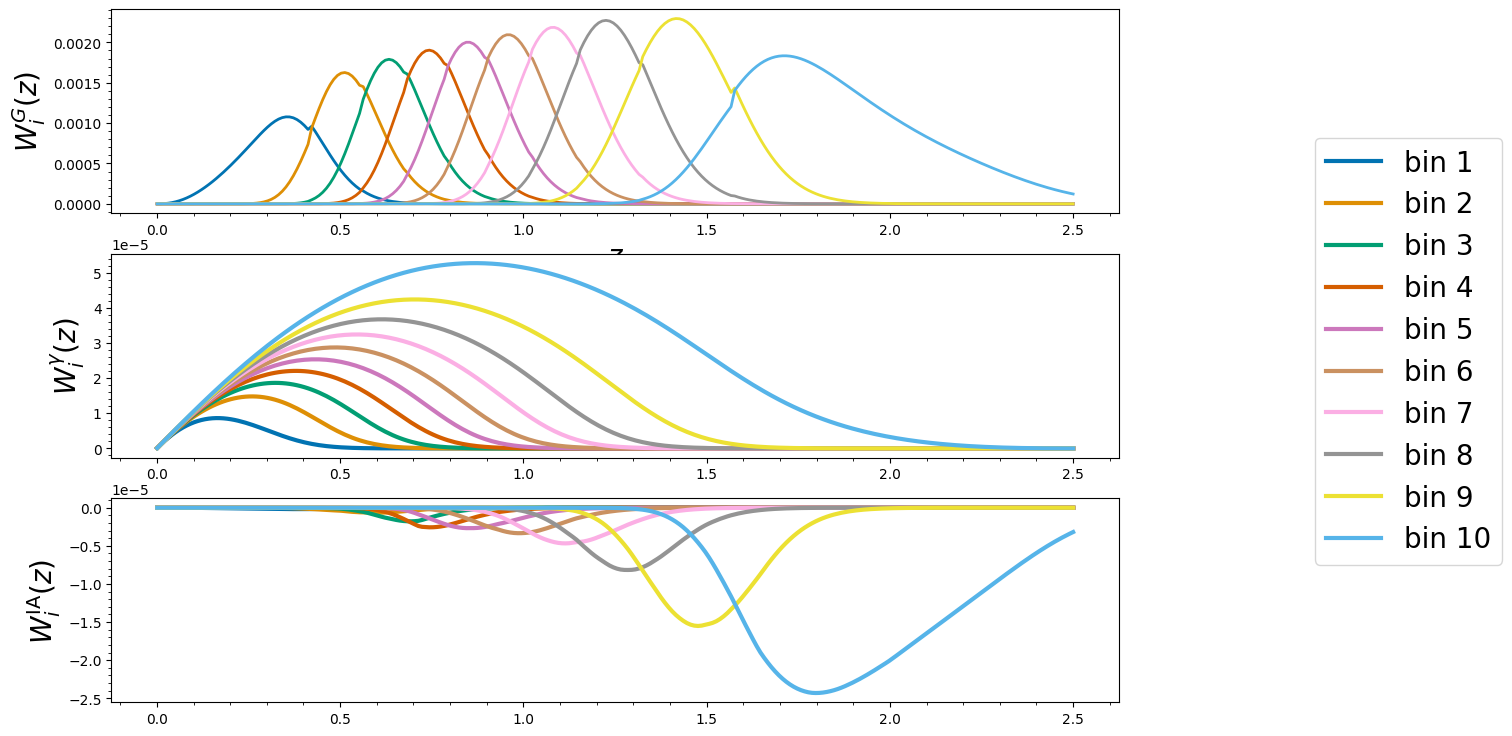

<Figure size 1000x800 with 0 Axes>

In [24]:
#Testing the generation of kernels and Cls

color=iter(snscolors)
fig, axs = plt.subplots(3,1, figsize=(13,9))
plt.figure(figsize=(10, 8))
for ind in photo_Cls.binrange:
    c = next(color)
    axs[0].plot(zz, photo_Cls.genwindow(zz, 'GCph', ind)[0], lw=2., color=c)
    axs[1].plot(zz, photo_Cls.genwindow(zz,   'WL', ind)[0], lw=3., color=c)
    axs[2].plot(zz, photo_Cls.genwindow(zz,   'WL', ind)[1], lw=3., color=c, label=r'bin %s' %ind)
axs[0].set_xlabel(r'$z$',fontsize=20)

axs[0].set_ylabel(r'$W_i^{G}(z)$',fontsize=20)
axs[1].set_ylabel(r'$W_i^{\gamma}(z)$',fontsize=20)
axs[2].set_ylabel(r'$W_i^\mathrm{IA}(z)$',fontsize=20)
axs[0].minorticks_on()
axs[1].minorticks_on()
axs[2].minorticks_on()
#axs[0].legend()
fig.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)

## Finally plot the 3x2pt $C^{XY}_{ij}(\ell) $

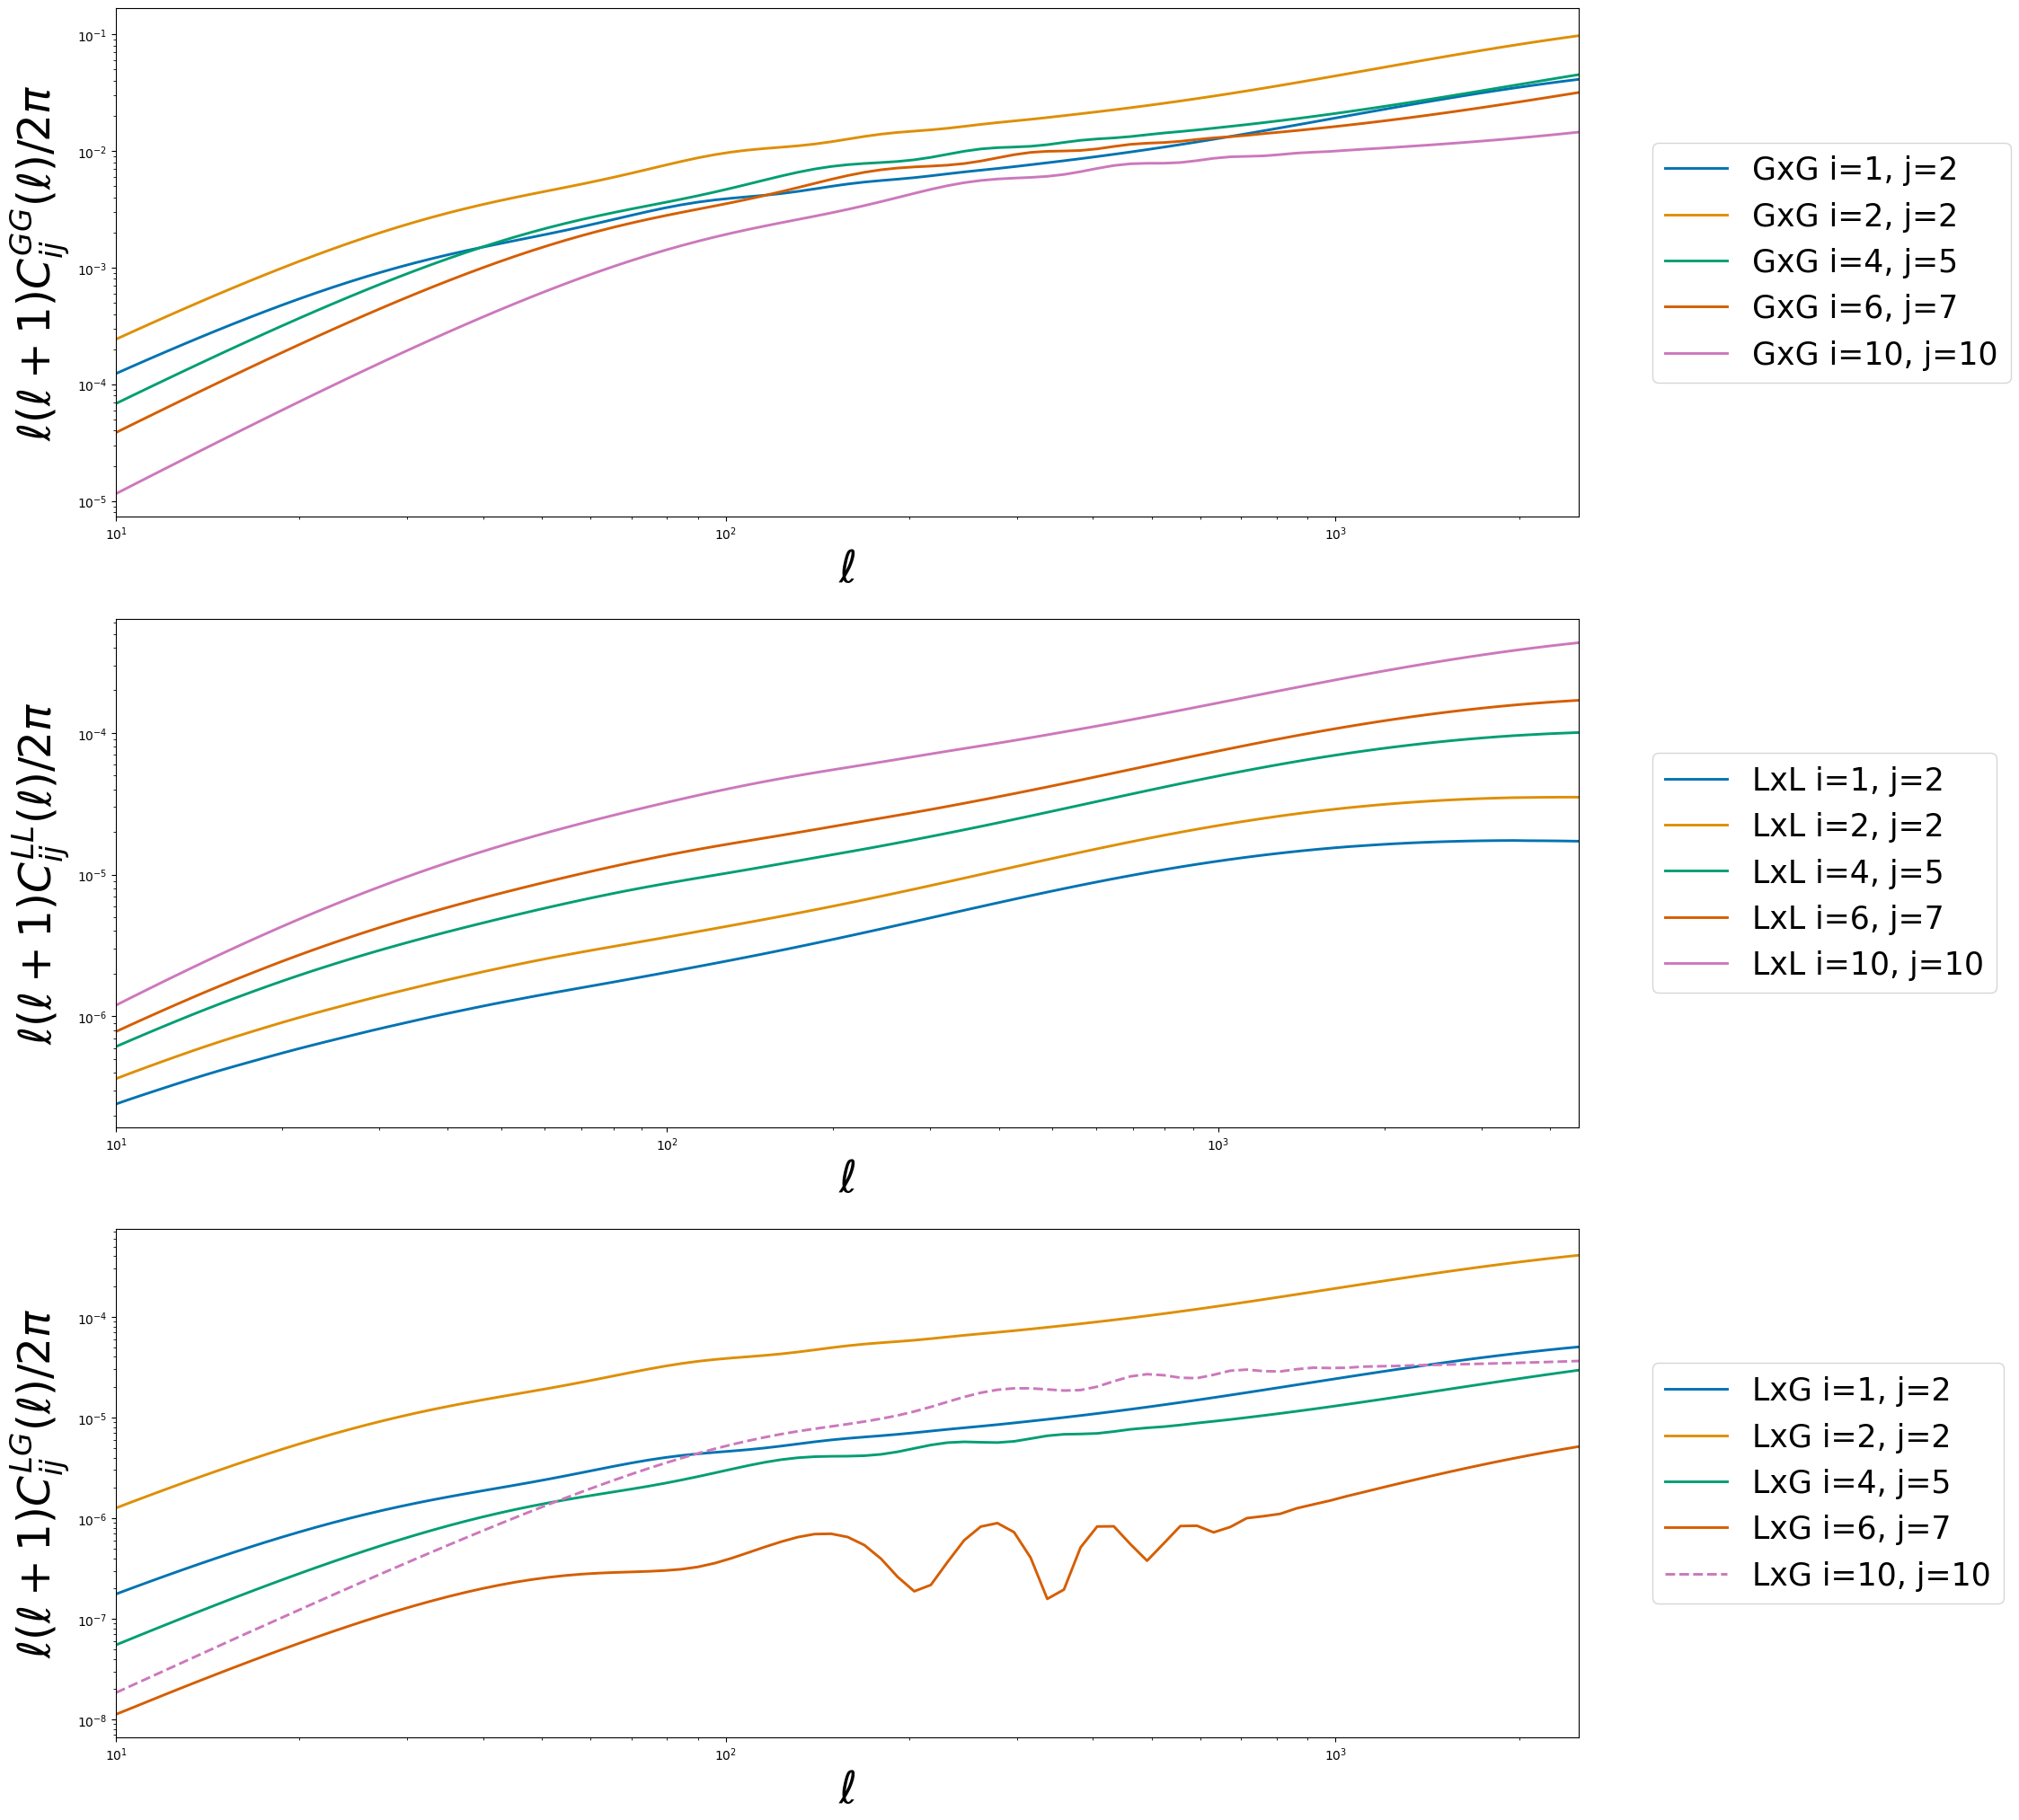

In [25]:
#Accessing LSS cls
cls = photo_Cls.result
l = cls['ells']
norm = l*(l+1)/(2*np.pi)

color=iter(snscolors)
fig, axs = plt.subplots(3,1, figsize=(21,25))
for bin1, bin2 in zip([1,2,4,6,10], [2,2,5,7,10]):
    c = next(color)   
    axs[0].loglog(l, norm*cls['GCph '+str(bin1)+'xGCph '+str(bin2)], color=c,
                label='GxG i='+str(bin1)+', j='+str(bin2), ls='-', lw=2.1)
    axs[1].loglog(l, norm*cls['WL '+str(bin1)+'xWL '+str(bin2)], color=c,
                label='LxL i='+str(bin1)+', j='+str(bin2), ls='-', lw=2.1)
    corr = norm*cls['WL '+str(bin1)+'xGCph '+str(bin2)]
    if np.mean(corr) < 0:
        ls = '--'
    else:
        ls = '-'
    axs[2].loglog(l, abs(corr), color=c,
                label='LxG i='+str(bin1)+', j='+str(bin2), ls=ls, lw=2.1)
axs[0].set_xlabel(r'$\ell$',fontsize=35)
axs[0].set_ylabel(r'$\ell(\ell+1)C_{ij}^{GG}(\ell)/2\pi$',fontsize=35)
axs[0].legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=25)
axs[0].set_xlim(10, 2500)
axs[1].set_xlabel(r'$\ell$',fontsize=35)
axs[1].set_ylabel(r'$\ell(\ell+1)C_{ij}^{LL}(\ell)/2\pi$',fontsize=35)
axs[1].legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=25)
axs[1].set_xlim(10, 4500)
axs[2].set_xlabel(r'$\ell$',fontsize=35)
axs[2].set_ylabel(r'$\ell(\ell+1)C_{ij}^{LG}(\ell)/2\pi$',fontsize=35)
axs[2].legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=25)
axs[2].set_xlim(10, 2500)
#plt.yscale('log')
#plt.xscale('log')
plt.show()

# Spectroscopic Power Spectrum

The observed power spectrum of galaxies can be related to the mater power spectrum by 

$$
P^\mathrm{th} = q_\| \times  q_\perp^2 \times K \times \mathrm{FoG} \times \mathrm{Err} \times P_{mm} + P^\mathrm{shot}.
$$
The factors in front are due to different observational effects. The factor $q_\|$ and $q_\perp$ are coming from the fact that we can only observe the redshift of galaxies and not their position.
To calculate the power spectrum we have to settle for a reference transformation. If this is different from the cosmology we used to compute the power spectrum in, we find 
$$
q_\| = H(z)/H^\mathrm{ref}(z) \quad\text{and}\quad q_\perp = D_A^\mathrm{ref}(z)/D_A(z)
$$

The factors $q_\mathrm{RSD}$ and $q_\mathrm{FOG}$ describe redshift space distortions and are given by
$$
K = \left(b+f\,\mu^2\right)^2\\
\mathrm{FoG} = 1+\left[f\,\sigma_p\,\mu^2\right]^2

$$
where $\mu$ denotes the angle under which we observe the structures.
The factor $q_\sigma$ is due to the resolution of the instrument and is given by
$$
\mathrm{Err} = \exp\left[-\sigma^2_\|\, k^2\, \mu^2 -\sigma_\perp^2 \,k^2\,\left(1- \mu^2\right)\right].
$$
Finaly, $P^\mathrm{shot}$ just is a constant term we add for shot noise.
The nonlinear power spectrum $P_{mm}$ is approximated as 
$$
P_{mm} \approx P_{dw} \coloneqq P_{mm}^\mathrm{lin}\,e^{-g} + P_{mm}\,(1-e^g),\\
g= \sigma_v^2 k^2\, \left((1-\mu^2)+\mu^2(1+f)^2\right)
$$

In [26]:
observables = ['GCsp']

### Pass options and settings to cosmicfish

In [27]:
cosmoFM_B = cosmicfish.FisherMatrix(fiducialpars=fiducial,
                                        options=options, 
                                        observables=observables,
                                        cosmoModel=options['cosmo_model'],
                                        surveyName=options['survey_name'])

**************************************************************
   _____               _     _____     __  
  / ___/__  ___ __ _  (_)___/ __(_)__ / /  
 / /__/ _ \(_-</  ' \/ / __/ _// (_-</ _ \ 
 \___/\___/___/_/_/_/_/\__/_/ /_/___/_//_/ 

**************************************************************
 This is the new Python version of the CosmicFish code.
**************************************************************
Custom fiducial parameters loaded

  -> Computing cosmology at the fiducial point

  ---> Cosmological functions obtained in:   5.63 s
No photo-z parameters specified. Using default: Euclid-like
No IA specified. Using default: eNLA
*** Dictionary of varied parameters in this Fisher Matrix run: 
{'Omegam': 0.01, 'Omegab': 0.01, 'w0': 0.01, 'wa': 0.01, 'h': 0.01, 'ns': 0.01, 'sigma8': 0.01, 'lnbgs8_1': 0.0001, 'lnbgs8_2': 0.0001, 'lnbgs8_3': 0.0001, 'lnbgs8_4': 0.0001, 'Ps_1': 0.0001, 'Ps_2': 0.0001, 'Ps_3': 0.0001, 'Ps_4': 0.0001}
                                          

2023-11-24 02:01:27,967	INFO worker.py:1673 -- Started a local Ray instance.


### Calculate the Power Spectrum

In [32]:
## Import the spectroscopic observable from an LSSsurvey as spobs
from cosmicfishpie.LSSsurvey import spectro_obs as spobs

spectro_Pk = spobs.ComputeGalSpectro(cosmoFM_B.fiducialcosmopars)


In class: ComputeGalSpectro  Entered ComputeGalSpectro

In class: ComputeGalSpectro  GalSpec initialization done in:   0.00 s


### "De-wiggling" of the Power Spectrum

To calculate the observed power spectrum we need to dewiggle it to find the non linear correction 

(0.01, 0.4)

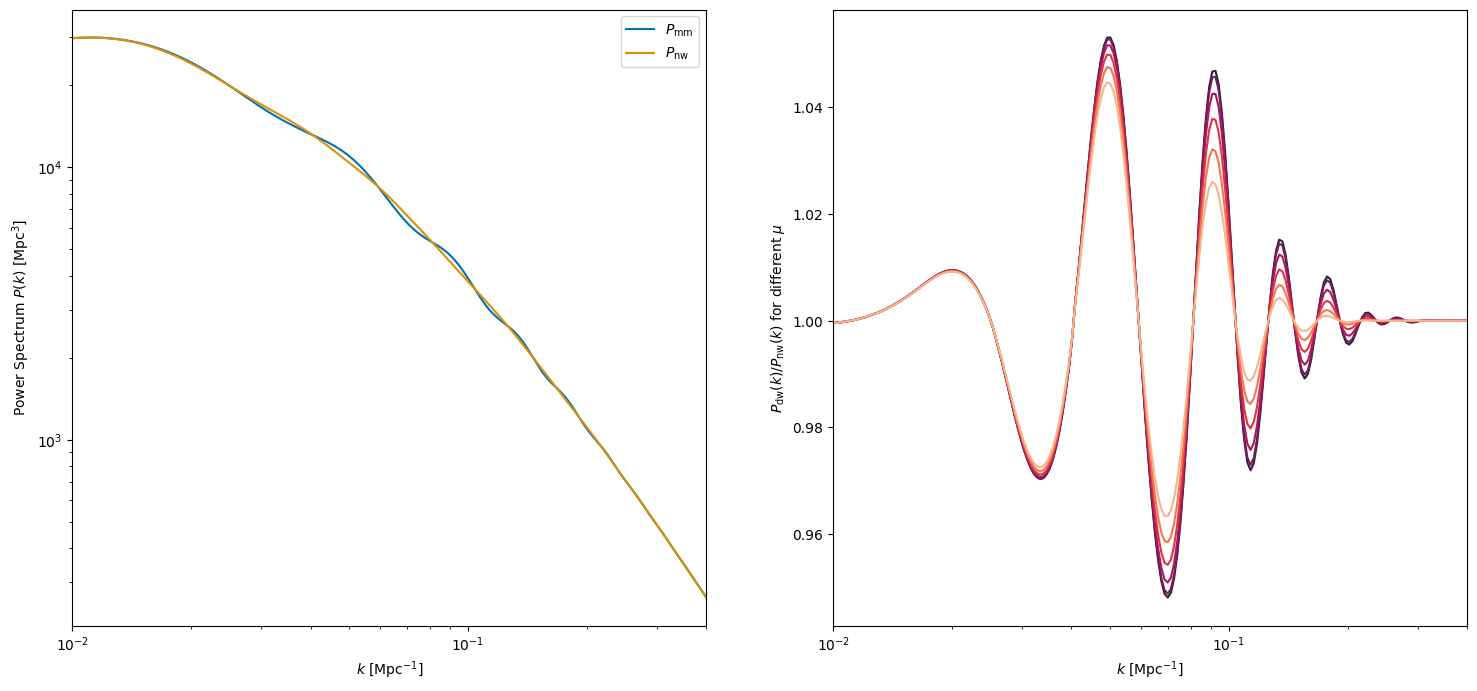

In [33]:
z=1
kk= np.logspace(-2,np.log10(0.4),200)

fig, axs = plt.subplots(1,2,figsize=(18,8))

color = iter(snscolors)

c = next(color)
axs[0].loglog(kk,spectro_Pk.cosmo.Pmm(z,kk),c=c,label='$P_\mathrm{mm}$')
c = next(color)
axs[0].loglog(kk,spectro_Pk.cosmo.nonwiggle_pow(z,kk),c=c,label='$P_\mathrm{nw}$')
axs[0].set_xlabel('$k$ [$\mathrm{Mpc}^{-1}$]')
axs[0].set_ylabel('Power Spectrum $P(k)$ [$\mathrm{Mpc}^{3}$]')
axs[0].legend()
axs[0].set_xlim([1e-2,0.4])

colormap = sns.color_palette("rocket")
colors = iter(colormap)
mus = np.linspace(0,1,6)
for mu in mus:
    c = next(colors)
    axs[1].plot(kk,spectro_Pk.dewiggled_pdd(z,kk,mu)/spectro_Pk.normalized_pnw(z,kk),c=c)

axs[1].set_xscale('log')
axs[1].set_xlabel('$k$ [$\mathrm{Mpc}^{-1}$]')
axs[1].set_ylabel('$P_\mathrm{dw}(k)$/$P_\mathrm{nw}(k)$ for different $\mu$')
axs[1].set_xlim([1e-2,0.4])


#### Compute the observed power spectrum at different redshifts and different angles 


In class: ComputeGalSpectro  observed P_gg computation took:   0.00 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.00 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.00 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.00 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.00 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.00 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.00 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.00 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.00 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.00 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.00 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.00 s


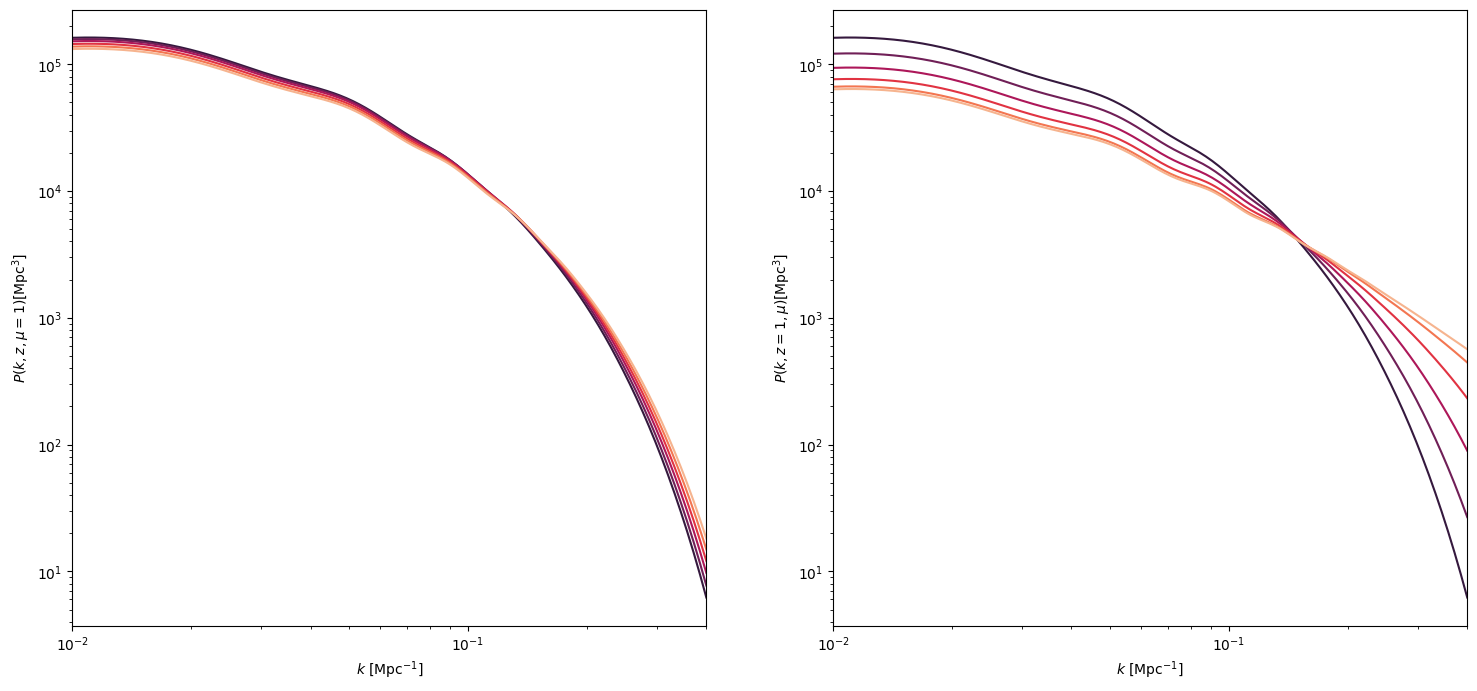

In [34]:

fig, axs = plt.subplots(1,2,figsize=(18,8))

colormap = sns.color_palette("rocket")
colors = iter(colormap)

zz= np.linspace(1,2,6)
for z in zz:
    c = next(colors)
    #axs[0].plot(kk,spectro_Pk.observed_Pgg(z,kk,1)/spectro_Pk.observed_Pgg(1,kk,1),c=c)
    axs[0].loglog(kk,spectro_Pk.observed_Pgg(z,kk,1),c=c)

axs[0].set_xlabel('$k$ [$\mathrm{Mpc}^{-1}$]')
axs[0].set_ylabel('$P(k,z,\mu=1)[\mathrm{Mpc}^3]$')
axs[0].set_xlim([1e-2,0.4])
axs[0].set_xscale('log')

colormap = sns.color_palette("rocket")
colors = iter(colormap)
mus = np.linspace(1,0,6)
for mu in mus:
    c = next(colors)
    #axs[1].plot(kk,spectro_Pk.observed_Pgg(1,kk,mu)/spectro_Pk.observed_Pgg(1,kk,1),c=c)
    axs[1].loglog(kk,spectro_Pk.observed_Pgg(1,kk,mu),c=c)

axs[1].set_xlabel('$k$ [$\mathrm{Mpc}^{-1}$]')
axs[1].set_ylabel('$P(k,z=1,\mu)[\mathrm{Mpc}^3]$')
axs[1].set_xlim([1e-2,0.4])
axs[1].set_xscale('log')


### Compare the Power Spectrum from two different cosmologies

In [36]:
sample = {"Omegam":0.32,
          "Omegab":0.06, #20% higher than the fiducial
          "h":0.737, #10% higher than the fiducal
          "ns":0.96,
          "sigma8":0.815584,
          "w0":-1.0,
          "wa":0.,
          "mnu":0.06,
          "Neff":3.044,
          }

spectro_Pk_sampled = spobs.ComputeGalSpectro(sample, cosmoFM_B.fiducialcosmopars)



In class: ComputeGalSpectro  Entered ComputeGalSpectro

In class: ComputeGalSpectro  GalSpec initialization done in:   5.52 s



In class: ComputeGalSpectro  observed P_gg computation took:   0.01 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.01 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.00 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.01 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.01 s

In class: ComputeGalSpectro  observed P_gg computation took:   0.01 s


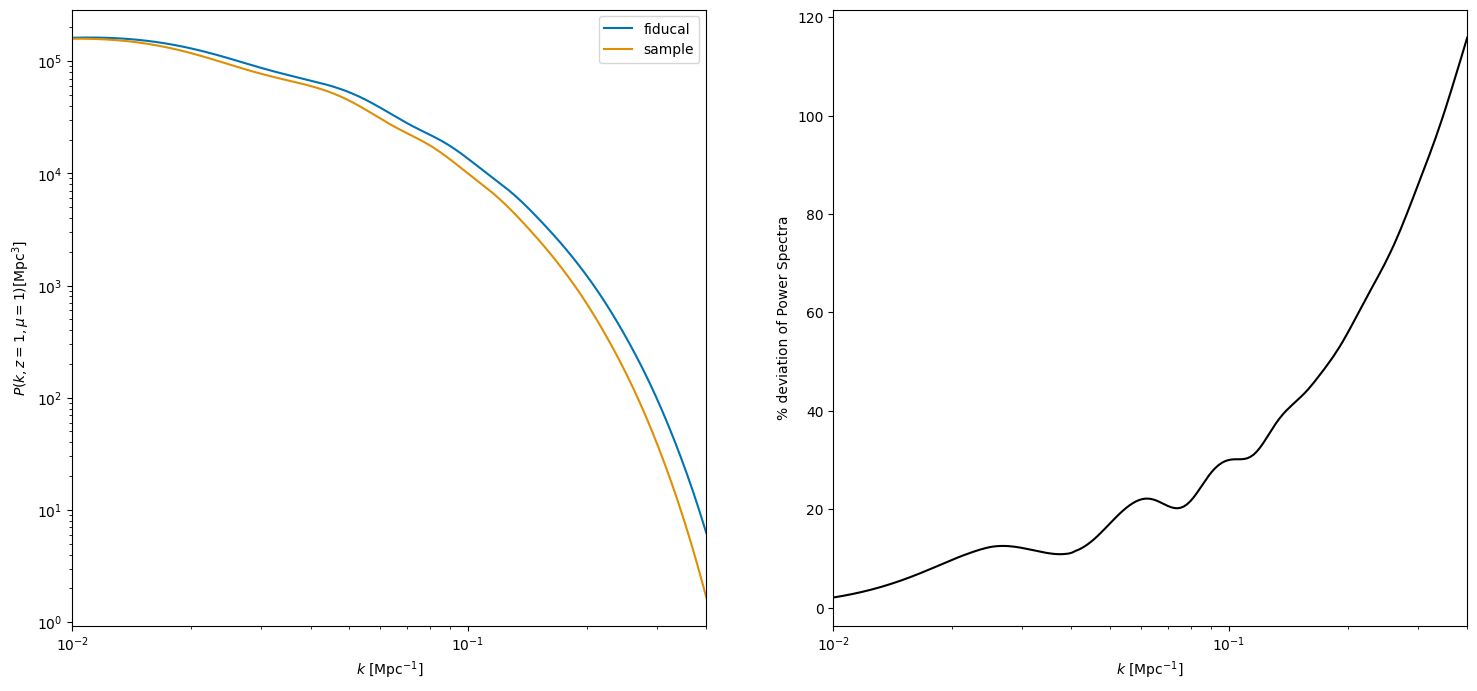

In [37]:
fig, axs = plt.subplots(1,2,figsize=(18,8))

colormap = sns.color_palette("colorblind")
colors = iter(colormap)

c = next(colors)
axs[0].loglog(kk,spectro_Pk.observed_Pgg(1,kk,1),c=c,label='fiducal')

c = next(colors)
axs[0].loglog(kk,spectro_Pk_sampled.observed_Pgg(1,kk,1),c=c,label='sample')

axs[0].set_xlabel('$k$ [$\mathrm{Mpc}^{-1}$]')
axs[0].set_ylabel('$P(k,z=1,\mu=1)[\mathrm{Mpc}^3]$')
axs[0].set_xlim([1e-2,0.4])
axs[0].legend()
axs[0].set_xscale('log')

axs[1].plot(kk,(spectro_Pk.observed_Pgg(1,kk,1)-spectro_Pk_sampled.observed_Pgg(1,kk,1))/(spectro_Pk.observed_Pgg(1,kk,1)+spectro_Pk_sampled.observed_Pgg(1,kk,1))*200,c='black')

axs[1].set_xlabel('$k$ [$\mathrm{Mpc}^{-1}$]')
axs[1].set_ylabel(r'% deviation of Power Spectra')
axs[1].set_xlim([1e-2,0.4])
axs[1].set_xscale('log')
